## Introduction
The MCF and HCC files represent well-known cancer cell lines.

In this analysis, we explored the genetic profiles of cells drawn from these cell lines, and grown under two different conditions - hypoxic (less oxygen) and normoxic (normal levels of oxygen).

To better understand the molecular mechanisms and biological effects of hypoxia in this cancer type, we compared the gene expression profiles through several quantitative and qualitative techniques, as well as trained classification algorithms to discern between the types.

The established techniques differentiate the cells’ genetic profiles fairly robustly, allowing identification of the more aggressive hypoxic cancer and potentially an alternation of a treatment as a result.

## Python libraries


In [1]:
import sys
import os
import random
import typing as T

import numpy as np 
from scipy.sparse import csr_matrix
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt       
import seaborn as sns  
import matplotlib.patches as mpatches
import pandas as pd
%matplotlib inline     
sns.set(color_codes=True)

random.seed(4123) # this is important for reproducibility

## Exploratory data analysis

In [2]:
# Reading HCC1806 datasets
hcc_meta = pd.read_csv('data/SmartSeq/HCC1806_SmartS_MetaData.tsv',delimiter="\t",engine='python', index_col=0)
ss_hcc_unfiltered = pd.read_csv('data/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt',delimiter='\ ',engine='python',index_col=0)

# Reading MCF7 dataset
mcf_meta = pd.read_csv('data/SmartSeq/MCF7_SmartS_MetaData.tsv',delimiter='\t',engine='python',index_col=0)
ss_mcf_unfiltered = pd.read_csv('data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt',delimiter='\ ',engine='python',index_col=0)

ss_hcc_prefiltered = pd.read_csv('data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt',delimiter='\ ',engine='python',index_col=0)
ss_mcf_prefiltered = pd.read_csv('data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt',delimiter='\ ',engine='python',index_col=0)

unfiltered_hcc_columns = list(ss_hcc_unfiltered.columns)
unfiltered_mcf_columns = list(ss_mcf_unfiltered.columns)

In [57]:
hcc_meta.head()

Cell Line  PCR Plate  Pos   
Filename                                                                       
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....   HCC1806          1  A10  \
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...   HCC1806          1  A12   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...   HCC1806          1   A1   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...   HCC1806          1   A2   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...   HCC1806          1   A3   

                                                   Condition  Hours Cell name   
Filename                                                                        
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     Normo     24      S123  \
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     Normo     24       S26   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...      Hypo     24       S97   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...      Hypo     24      S104   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...      Hypo     24        S4   

                                                                 PreprocessingTag   
Filename                                                                            
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  Aligned.sortedByCoord.out.bam  \
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  Aligned.sortedByCoord.out.bam   

                                                    ProcessingComments  
Filename                                                                
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  STAR,FeatureCounts  
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  STAR,FeatureCounts  
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  STAR,FeatureCounts  
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  STAR,FeatureCounts  
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  STAR,FeatureCounts

### Dataset Description
#### Metadata
Two metadata files are available, one for each experiment, namely HCC1806 and MCF7. The cells are cultured in four distinct PRC plates inside the gene sequencing device (to control batch effects), where each plate comprises 8*12 wells. Each well is utilized to cultivate and sequence a single sample of cells.
**Columns**
- Filename: string – Filenames are used as the label for each cell sample. ‘.bam’ is a standard file format for DNA sequencing data after alignment or assembly. 
- Cell Line: string – Dataset contains two cell lines HCC1806 and MCF7. Each cell line in their separate respective files. 
- PCR Plate (only present in HCC1806_SmartS_MetaData.tsv): integer from 1 to 4 – Indicates the PRC Plate where the sample was grown. 
- Lane (only present in MCF7_SmartS_MetaData.tsv): string – Indicates the PCR Plate where the sample was grown.
- Pos: string – Position of the cell on the PCR Plate. 
- Condition: string – either "Hypo" or "Norm." As noted before, tumor hypoxia could be a deleterious factor in cancer therapies.
- Hours: integer – The number of hours the cells were exposed to the condition. 72 for MCF7 and 24 for HCC1806. 
- Cell name: string – The name given two each sample. Format: ‘S’ + number from 1 to 384 = 4 * 8 * 12. 
- ProcessingTag: string – ‘Aligned.sortedByCoord.out.bam’ in every row. 
- Processing Comments: string – 'STAR,FeatureCounts’ in every row.

**Shape of HCC1806_SmartS_MetaData.tsv**: (243, 8)

**Shape of MCF7_SmartS_MetaData.tsv**: (383, 8)

**Note**: Number of rows is less than 384 which means that samples were filtered out or not all of the PRC Plate cells were used.

#### Unfiltered Data
Shape of HCC1806_SmartS_Unfiltered_Data.txt: (23396, 243)

Shape of MCF7_SmartS_Unfiltered_Data.txt: (22934, 383)

The dataset is organized in a tabular format, where the columns correspond to the specific cell sample names, and the rows pertain to the gene names. Each column represents the raw gene expression levels of a cell sample, while the rows indicate the expression values of a single gene across multiple samples. The count data used for differential expression analysis is a measure of the number of sequence reads originating from a specific gene. The count value is directly proportional to the level of gene expression in the given sample, with a higher count indicative of a greater number of reads associated with that gene and thus, an increased gene expression level in the sample.

### Imputation

We ensure that the dataset does not contain any NaN values. As there are no missing values, we can proceed with the rest of the analysis.

In [8]:
hcc_nan_count = ss_hcc_unfiltered.isna().sum().sum()
mcf_nan_count = ss_mcf_unfiltered.isna().sum().sum()
print(f"HCC NaN Count: {hcc_nan_count}")
print(f"MCF NaN Count: {hcc_nan_count}")

HCC NaN Count: 0
MCF NaN Count: 0


### Cell Quality Check (QC)
Cell QC is a crucial step in scRNA-seq data analysis pipelines. It is the process of identifying and removing low-quality cells, which can affect the accuracy of downstream analyses, and can improve the accuracy of differential gene expression analysis, clustering, and other downstream analyses. This process involves assessing various quality control metrics such as the number of genes detected, the total count of reads, and the percentage of mitochondrial reads to determine the health of individual cells.
In order to identify low-quality cells, we perform the following procedures:
- We generate a visual representation of the total count of RNA molecules, expressed genes, and mitochondrially derived genes detected in each cell.
- Next, we establish upper and lower thresholds to eliminate any cells that exhibit signs of damage or deviate from the norm.
- In addition to these steps, we utilize house-keeping genes as a further tool to filter out damaged cells.

In [19]:
ss_hcc_tot = ss_hcc_unfiltered.copy()
ss_mcf_tot = ss_mcf_unfiltered.copy()

def count_genes(col: pd.Series) -> float:
    return len(col[col>0]) - 1
def calc_mt_pct(col: pd.Series) -> float:
    return col[col.index.str.startswith('"MT')].sum() / col["nCount_RNA"]

def add_tot(df: pd.DataFrame) -> pd.DataFrame:
    df.loc["nCount_RNA"] = df.sum()
    df.loc["nFeature_RNA"] = df.apply(count_genes, axis=0)
    df.loc["Percent_MT"] = df.apply(calc_mt_pct, axis=0)    
    return df

ss_hcc_tot = add_tot(ss_hcc_tot)
ss_mcf_tot = add_tot(ss_mcf_tot)

In [20]:
MAX_MT_PCT = .07
MIN_NFEATURE = 5000

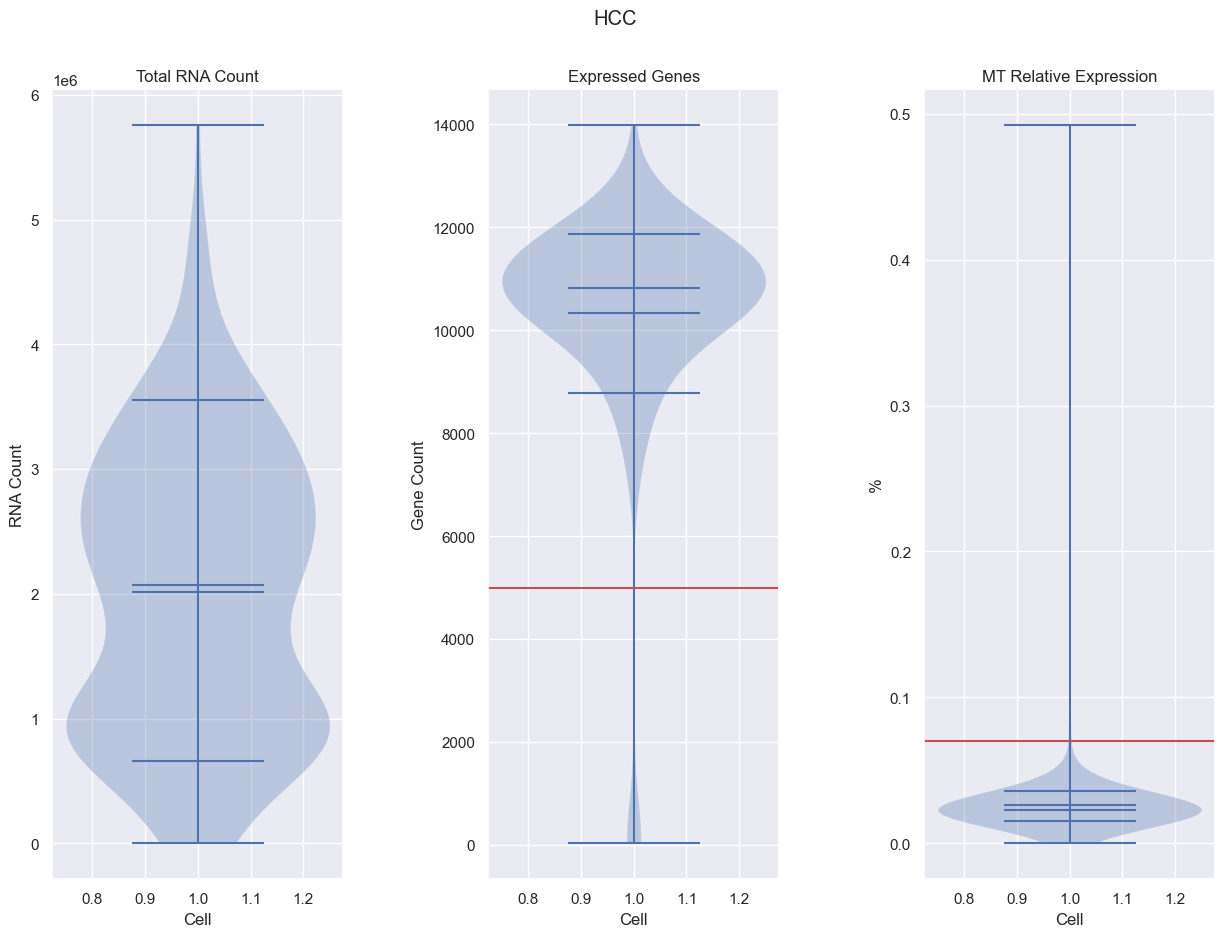

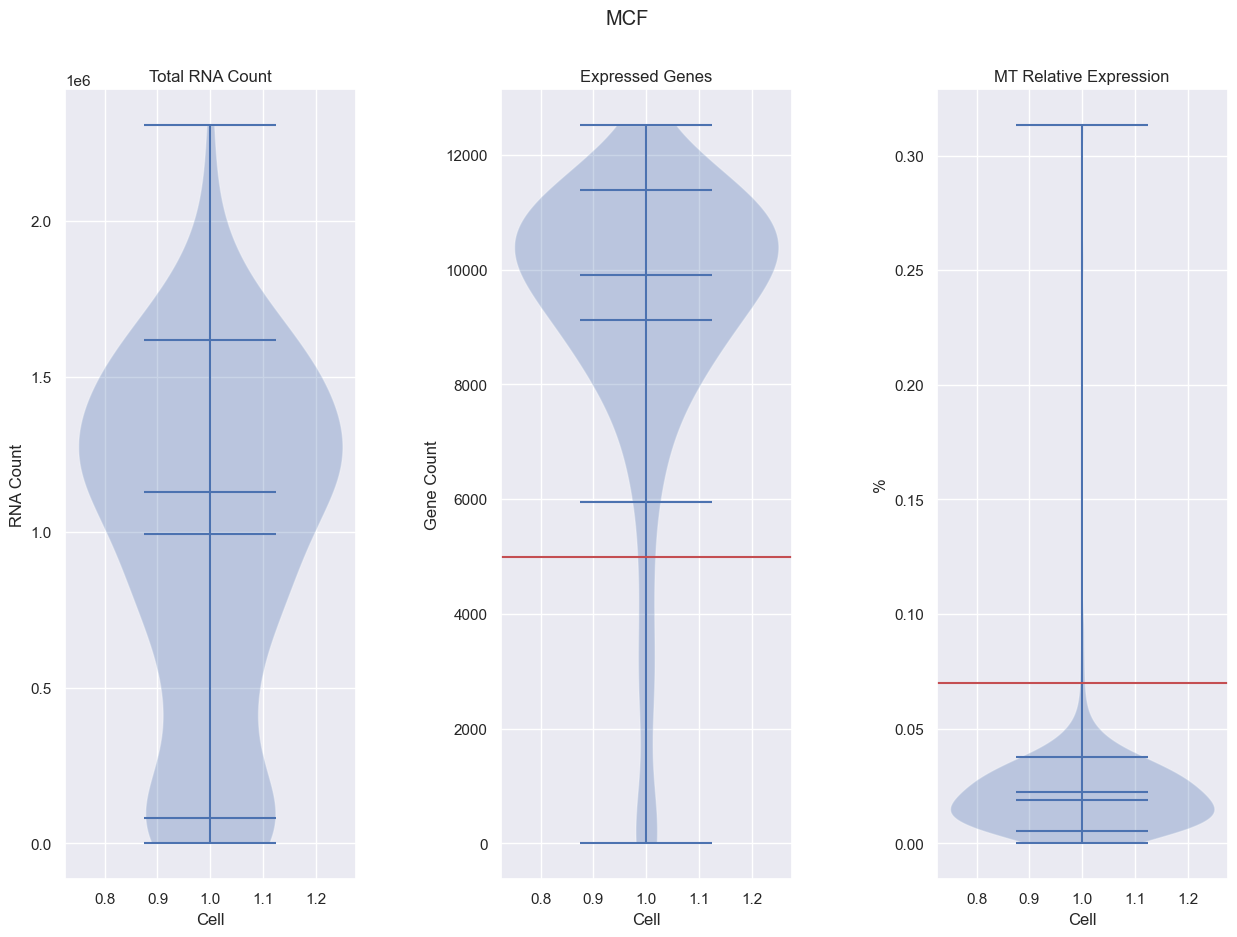

In [21]:
def visualize_counts(df: pd.DataFrame, title: str):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,10))
    plt.suptitle(title)
    ax1.violinplot(df.loc["nCount_RNA"], showmeans=True, showmedians=True, showextrema=True, quantiles=[.1,.9], points=1000)
    ax1.set_title('Total RNA Count')
    ax1.set_xlabel('Cell')
    ax1.set_ylabel('RNA Count')

    ax2.violinplot(df.loc["nFeature_RNA"], showmeans=True, showmedians=True, showextrema=True, quantiles=[.1,.9], points=1000)
    ax2.set_title('Expressed Genes')
    ax2.set_xlabel('Cell')
    ax2.set_ylabel('Gene Count')
    ax2.axhline(y=MIN_NFEATURE, color="r")

    ax3.violinplot(df.loc["Percent_MT"], showmeans=True, showmedians=True, showextrema=True, quantiles=[.1,.9], points=1000)
    ax3.set_title('MT Relative Expression')
    ax3.set_xlabel('Cell')
    ax3.set_ylabel('%')
    ax3.axhline(y=MAX_MT_PCT, color="r")
    plt.subplots_adjust(top=.9, wspace=0.5)
    plt.show()

visualize_counts(ss_hcc_tot, "HCC")
visualize_counts(ss_mcf_tot, "MCF")

After analyzing the visualizations, we determined the cut-off thresholds to eliminate low quality cells. Specifically, we selected the following criteria:
- A minimum of 5000 unique genes expressed per cell
- A maximum of 7% mitochondrial genes expressed per cell
Note that the distribution of `nFeature_RNA` has a small right tail, and therefore we did not establish an upper threshold for this variable.

In [22]:
ss_hcc_filter1 = ss_hcc_tot.loc[:, (ss_hcc_tot.loc["Percent_MT"] < MAX_MT_PCT) & (ss_hcc_tot.loc["nFeature_RNA"] > MIN_NFEATURE)]
f1_removed = len(ss_hcc_tot.columns) - len(ss_hcc_filter1.columns)
print(f"First filter removed {f1_removed} cells in HCC.")

ss_mcf_filter1 = ss_mcf_tot.loc[:, (ss_mcf_tot.loc["Percent_MT"] < MAX_MT_PCT) & (ss_mcf_tot.loc["nFeature_RNA"] > MIN_NFEATURE)]
f1_removed = len(ss_mcf_tot.columns) - len(ss_mcf_filter1.columns)
print(f"First filter removed {f1_removed} cells in MCF.")

First filter removed 11 cells in HCC.
First filter removed 35 cells in MCF.


Now, we generate visualizations of the expressed gene count and the proportion of mitochondrial genes relative to the total RNA count and look for outliers. We verify that outliers are removed after the first layer of filtering.

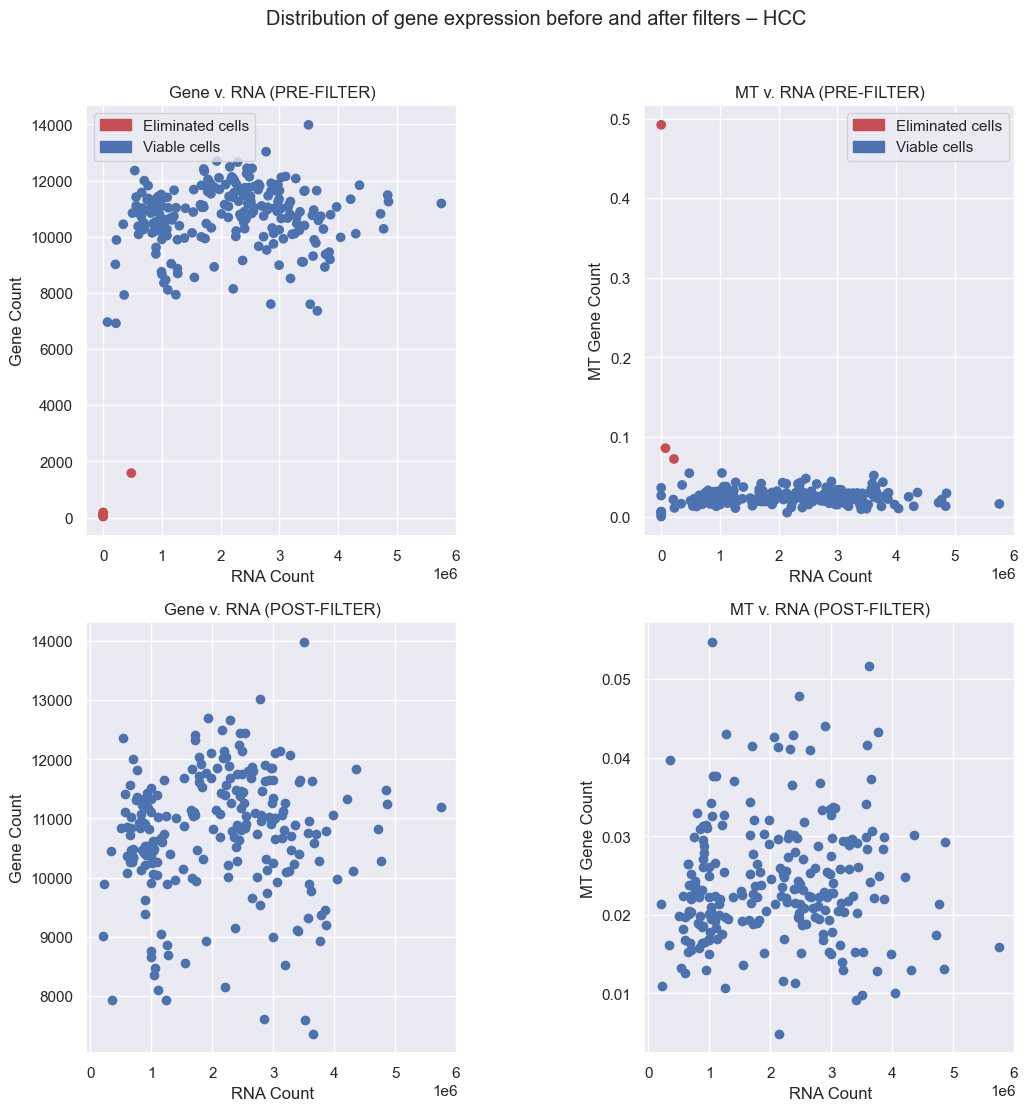

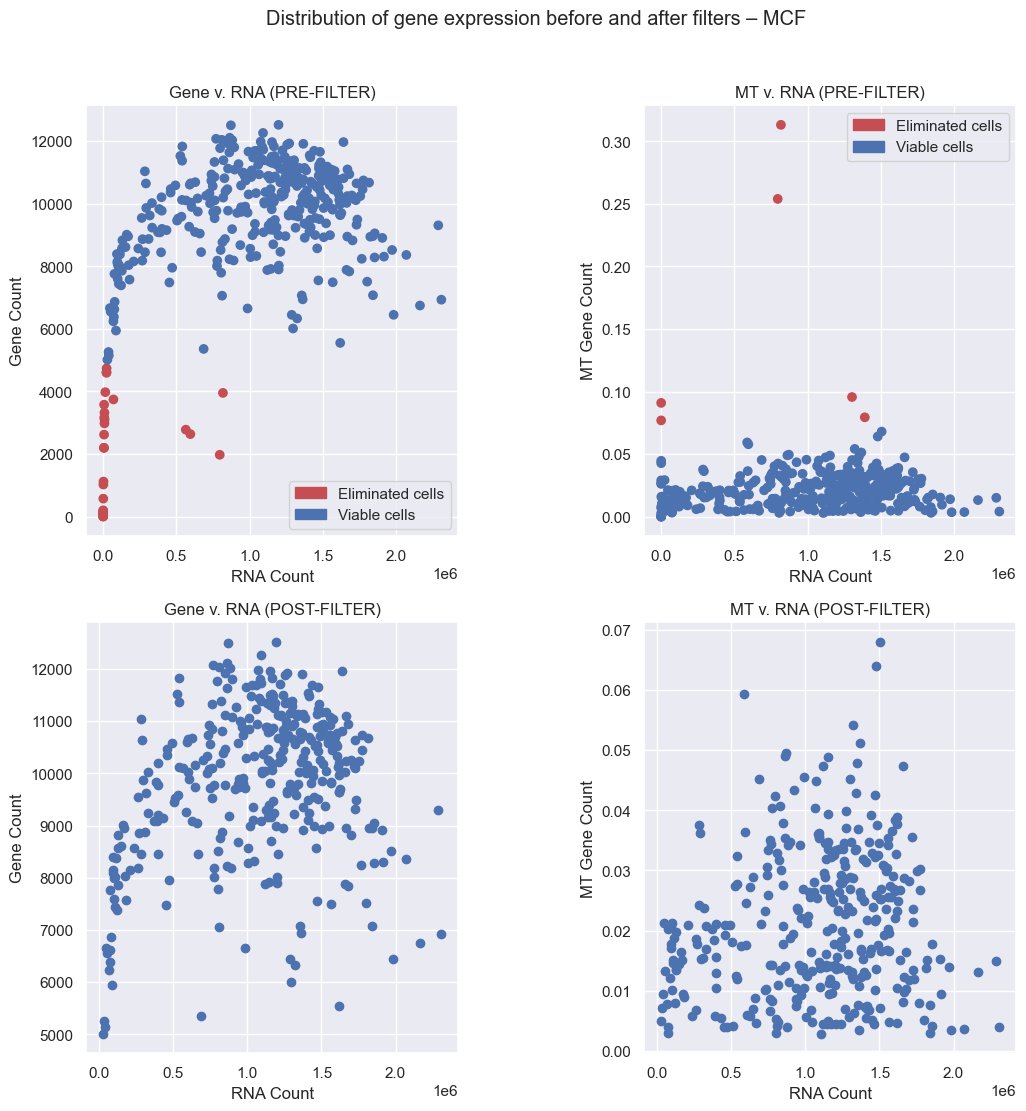

In [23]:
def plt_color_nfeat(y: pd.Series) -> T.List:
    return ["r" if val < MIN_NFEATURE else "b" for val in list(y)]
def plt_color_mt(y: pd.Series) -> T.List:
    return ["r" if val > MAX_MT_PCT else "b" for val in list(y)]

def visualize_post_pre_filter(df: pd.DataFrame, df_filtered: pd.DataFrame, title: str):

    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))
    ax1.scatter(df.loc["nCount_RNA"], df.loc["nFeature_RNA"], c=plt_color_nfeat(df.loc["nFeature_RNA"]))
    ax1.set_title('Gene v. RNA (PRE-FILTER)')
    ax1.set_xlabel('RNA Count')
    ax1.set_ylabel('Gene Count')
    r_patch = mpatches.Patch(color='r', label='Eliminated cells')
    b_patch = mpatches.Patch(color='b', label='Viable cells')
    ax1.legend(handles=[r_patch, b_patch])

    ax2.scatter(df.loc["nCount_RNA"], df.loc["Percent_MT"], c=plt_color_mt(df.loc["Percent_MT"]))
    ax2.set_title('MT v. RNA (PRE-FILTER)')
    ax2.set_xlabel('RNA Count')
    ax2.set_ylabel('MT Gene Count')
    ax2.legend(handles=[r_patch, b_patch])

    ax3.scatter(df_filtered.loc["nCount_RNA"], df_filtered.loc["nFeature_RNA"])
    ax3.set_title('Gene v. RNA (POST-FILTER)')
    ax3.set_xlabel('RNA Count')
    ax3.set_ylabel('Gene Count')

    ax4.scatter(df_filtered.loc["nCount_RNA"], df_filtered.loc["Percent_MT"])
    ax4.set_title('MT v. RNA (POST-FILTER)')
    ax4.set_xlabel('RNA Count')
    ax4.set_ylabel('MT Gene Count')
    plt.suptitle(f"Distribution of gene expression before and after filters – {title}")
    plt.subplots_adjust(top=.9, wspace=0.5)
    plt.show()

visualize_post_pre_filter(ss_hcc_tot, ss_hcc_filter1, "HCC")
visualize_post_pre_filter(ss_mcf_tot, ss_mcf_filter1, "MCF")


Housekeeping genes are essential for maintaining basic cellular functions that are critical for the survival of cells, regardless of their specific functions in the tissue or organism. Hence, they are anticipated to be expressed across all cells of an organism under normal conditions, irrespective of their developmental stage, tissue type, or exposure stimuli. Housekeeping genes are commonly used as a quality control tool to identify and eliminate low quality cells in gene expression studies. By comparing the expression levels of control genes across all cells in a sample, it is possible to identify any cells that have deviated from the expected expression levels, which may be indicative of low quality or damaged cells.

We'll use the following list of genes for internal control ([source](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2002-3-7-research0034)):
1. ACTB (beta-actin)
2. GAPDH (glyceraldehyde-3-phosphate dehydrogenase)
3. HPRT1 (hypoxanthine phosphoribosyltransferase 1)
4. RPL13A (ribosomal protein L13a)
5. TBP (TATA-box binding protein)
6. UBC (ubiquitin C)
7. PGK1 (phosphoglycerate kinase 1)
8. B2M (beta-2-microglobulin)
9. PPIA (peptidylprolyl isomerase A)
10. SDHA (succinate dehydrogenase complex subunit A)
    
First, we plot their expression distribution to gain more insights.

In [24]:
CONTROL_GENES = ['"ACTB"','"B2M"','"GAPD"','"HMBS"','"HPRT1"','"RPL13A"','"SDHA"','"TBP"','"UBC"','"YWHAZ"']

Initially, we plot the count distribution of every housekeeping gene across all the cells and highlight the median value along with 1.5 standard deviations below the median line.

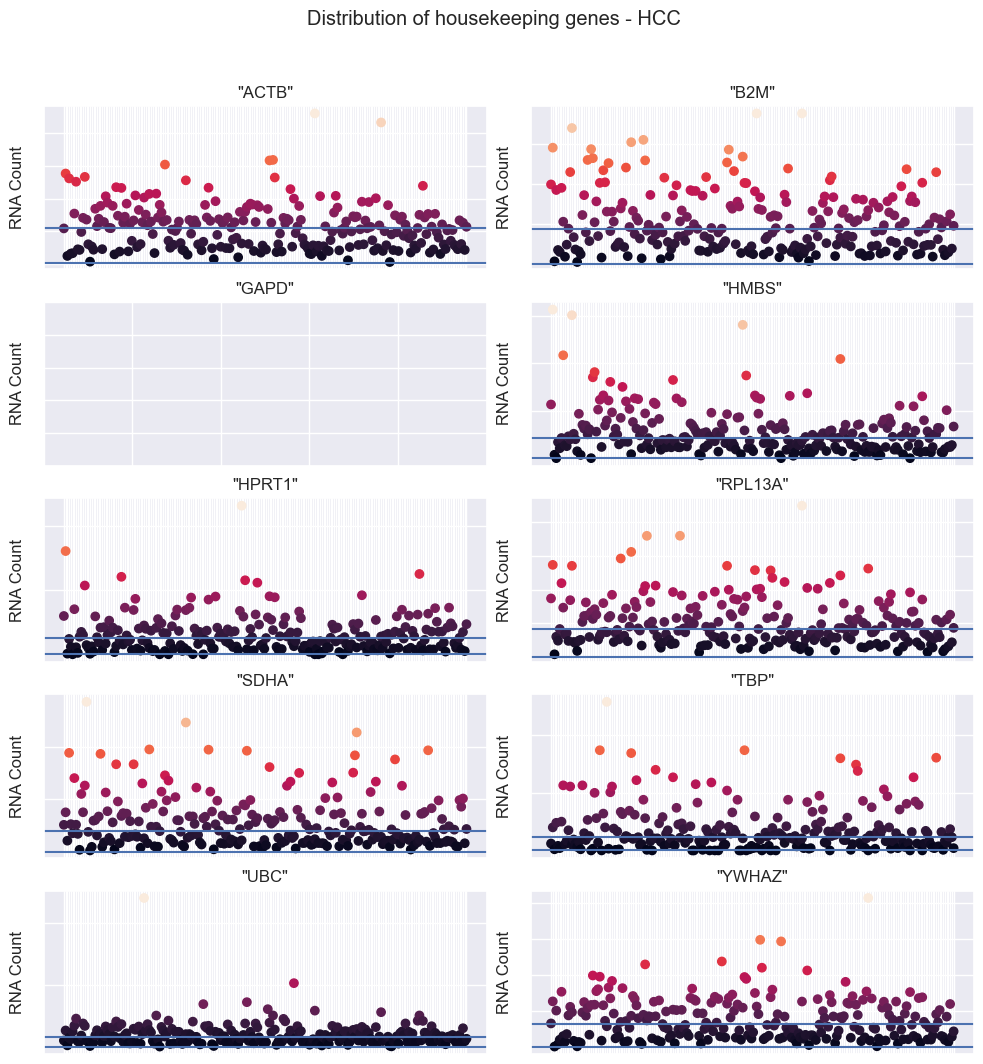

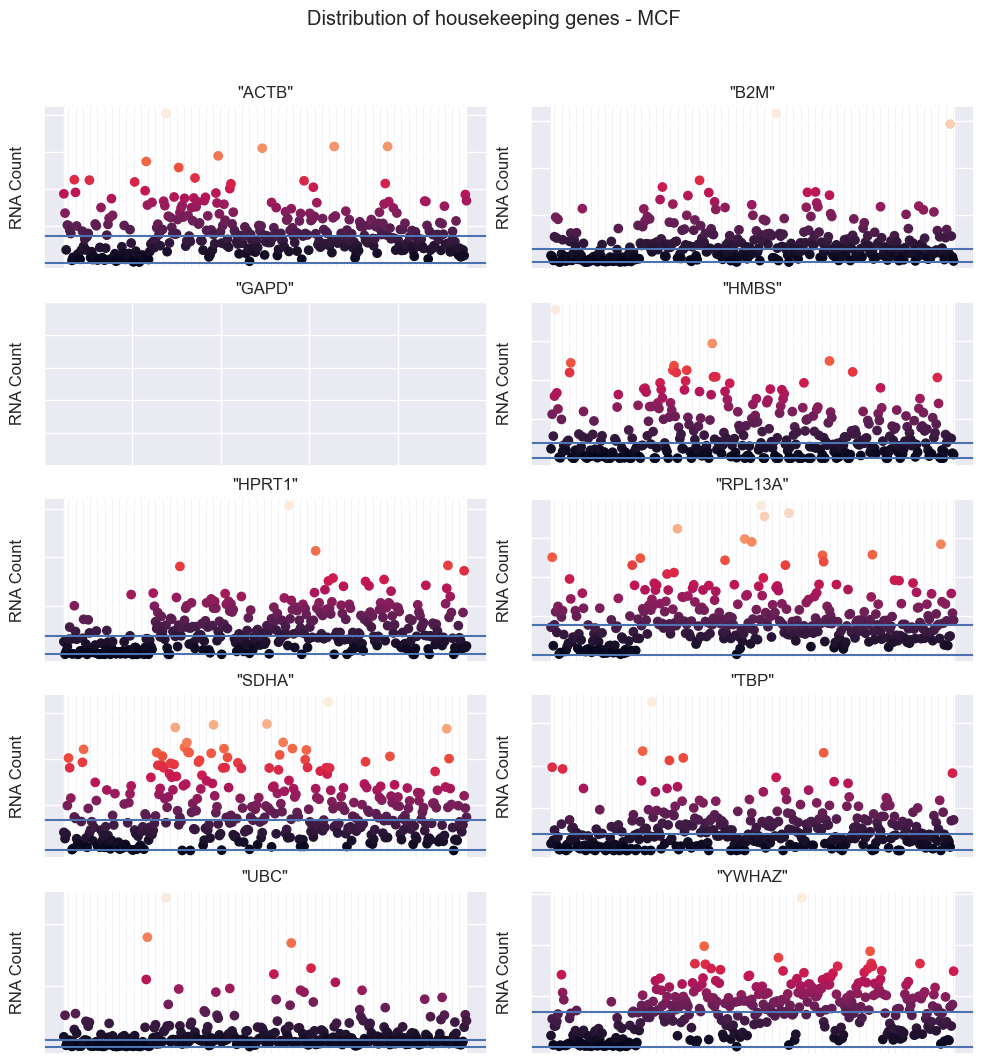

In [25]:
def visualize_control_genes(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(5,2, figsize=(12, 12))
    ax = ax.flatten()
    plt.suptitle(f"Distribution of housekeeping genes - {title}")

    for ix, gene in enumerate(CONTROL_GENES):
        try:
            ax[ix].set_yticklabels([])
            ax[ix].set_xticklabels([])
            ax[ix].set_title(gene)
            ax[ix].set_ylabel('RNA Count')
            y = df.loc[gene]
            ax[ix].scatter(df.columns, y, alpha=1, c=y)
            median = np.median(y)
            std = np.std(y)
            ax[ix].axhline(y=median)
            ax[ix].axhline(y=max(median-1.5*std, 0))
        except KeyError:
            pass
    
    plt.subplots_adjust(top=.9, wspace=0.1)
    plt.show()
        
visualize_control_genes(ss_hcc_filter1, "HCC")
visualize_control_genes(ss_mcf_filter1, "MCF")

Next, we calculate the mean expression level of the housekeeping genes for each cell and visualize its distribution.

In [26]:
def calc_mean_control_exp(col: pd.Series) -> float:
    return col[col.index.isin(CONTROL_GENES)].mean()

def add_mean_control(df: pd.DataFrame):
    df.loc["Mean_Control"] = df.apply(calc_mean_control_exp, axis=0)
    return df

ss_hcc_filter1 = add_mean_control(ss_hcc_filter1)
ss_mcf_filter1 = add_mean_control(ss_mcf_filter1)

C:\Users\termi\AppData\Local\Temp\ipykernel_22516\4151620316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc["Mean_Control"] = df.apply(calc_mean_control_exp, axis=0)
C:\Users\termi\AppData\Local\Temp\ipykernel_22516\4151620316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc["Mean_Control"] = df.apply(calc_mean_control_exp, axis=0)


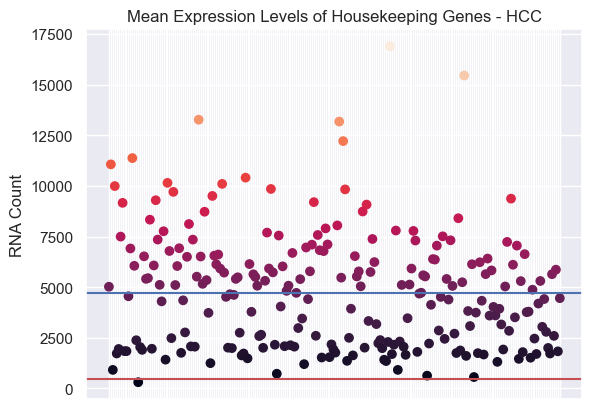

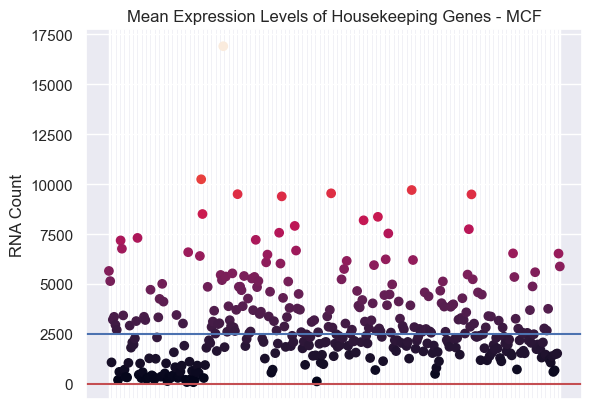

In [30]:
control_cutoff = 0
def visualize_control_cutoff(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(1)
    ax.set_xticklabels([])
    ax.set_title(f"Mean Expression Levels of Housekeeping Genes - {title}")
    ax.set_ylabel('RNA Count')
    y = df.loc["Mean_Control"]
    ax.scatter(df.columns, y, alpha=1, c=y)
    median = np.median(y)
    std = np.std(y)
    control_cutoff = max(median-1.5*std, 0)
    ax.axhline(y=median)
    ax.axhline(y=control_cutoff, color="r")
visualize_control_cutoff(ss_hcc_filter1, "HCC")
visualize_control_cutoff(ss_mcf_filter1, "MCF")

In [33]:
ss_hcc_final = ss_hcc_filter1.loc[:, (ss_hcc_filter1.loc["Mean_Control"] >= control_cutoff)]
f2_removed = len(ss_hcc_filter1.columns) - len(ss_hcc_filter1.columns)
print(f"Second filter removed {f2_removed} cell(s) in HCC.")

ss_mcf_final = ss_mcf_filter1.loc[:, (ss_mcf_filter1.loc["Mean_Control"] >= control_cutoff)]
f2_removed = len(ss_mcf_filter1.columns) - len(ss_mcf_filter1.columns)
print(f"Second filter removed {f2_removed} cell(s) in MCF.")

Second filter removed 0 cell(s) in HCC.
Second filter removed 0 cell(s) in MCF.


### Log Normalization

#### Why do we need normalization? 

**Main goals for normalization:**
- *Scaling data*: Normalizing data is a widely discussed objective that aims to eliminate the influence of feature scale and emphasize relative variance. A good resource is the scikit-learn documentation on preprocessing and scaling data: https://scikit-learn.org/stable/modules/preprocessing.html

- *Removing skewness*: The consideration of skewness is crucial as it has the potential to impact the distribution of data and subsequently affect the precision and performance of machine learning algorithms. https://arxiv.org/pdf/1906.08510.pdf

- *Improving convergence*: Convergence rate of optimization algorithms could be enhanced by normalization. "Data Preprocessing for Machine Learning: Normalization, Scaling and More" by Bhavesh Bhatt: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Below, we display <a href="https://seaborn.pydata.org/generated/seaborn.violinplot.html">violin plots</a> of gene expression values profiles for 10 randomly selected cell samples in each dataset. 

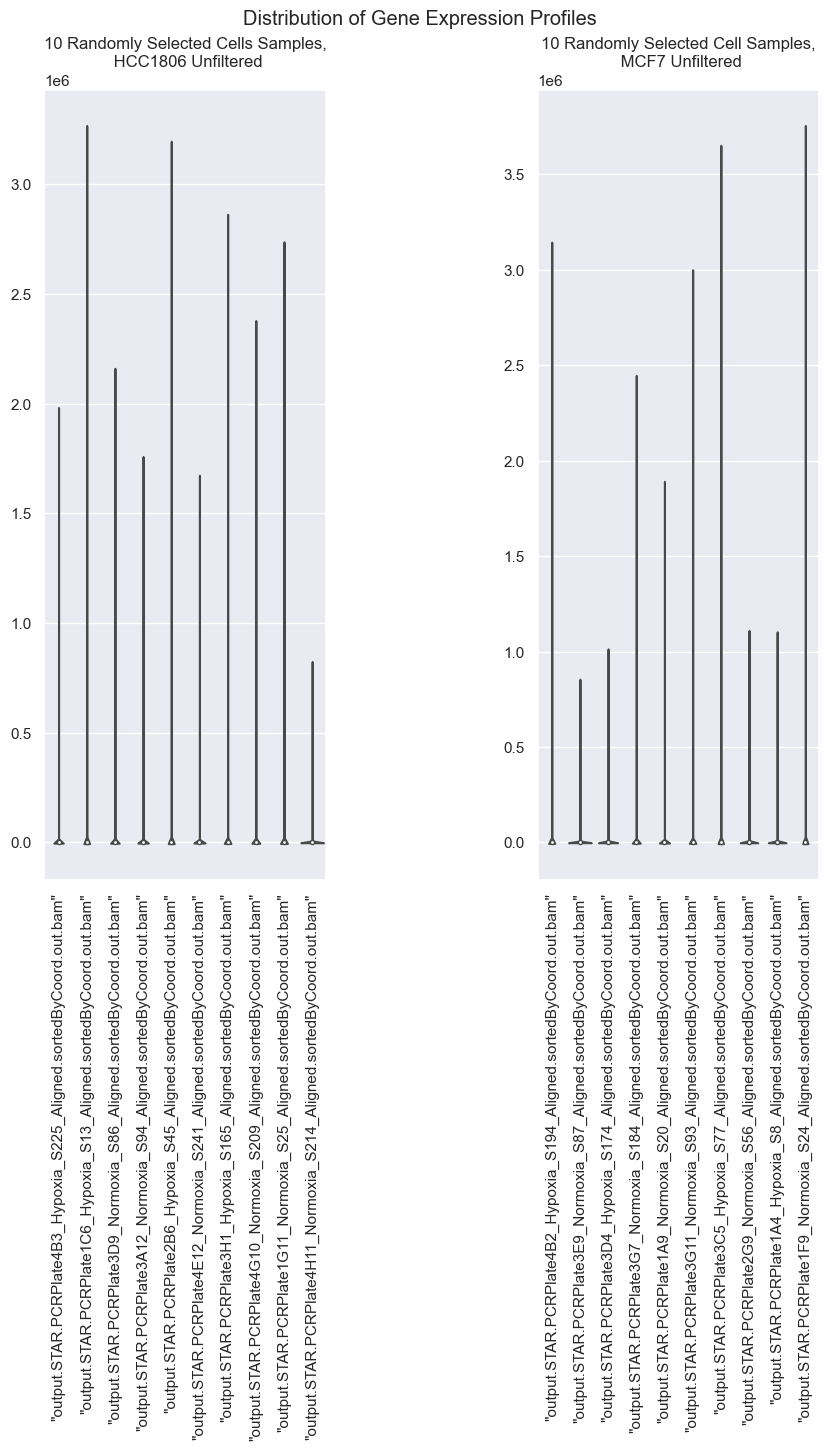

In [34]:
hcc_columns = list(ss_hcc_final.columns)
mcf_columns = list(ss_hcc_final.columns)
hcc_rows = list(ss_hcc_final.index)
mcf_rows = list(ss_hcc_final.index)

hcc_column_sample = random.sample(hcc_columns, 10)
mcf_column_sample = random.sample(mcf_columns, 10)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

plt.suptitle("Distribution of Gene Expression Profiles")
axs[0].set_title("10 Randomly Selected Cells Samples,\n HCC1806 Unfiltered")
plot = sns.violinplot(data=ss_hcc_final[hcc_column_sample], ax=axs[0])
plt.setp(plot.get_xticklabels(), rotation=90)

axs[1].set_title("10 Randomly Selected Cell Samples,\n MCF7 Unfiltered")
plot = sns.violinplot(data=ss_hcc_final[mcf_column_sample], ax=axs[1])
plt.setp(plot.get_xticklabels(), rotation=90)

plt.subplots_adjust(top=0.9, wspace=0.75)
plt.show()



Visually, we can see that the distributions are highly skewed and non-normal. We can verify this by plotting the <i>skewness</i> of the distributions. <i>Skewness</i> is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point(<a href="https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Skewness%20is%20a%20measure%20of,relative%20to%20a%20normal%20distribution.">link</a>).

For univariate data $Y_1, Y_2, ..., Y_N$, the formula for <i>skewness</i> is:

$$g_{1} = \frac{\sum_{i=1}^{N}(Y_{i} - \bar{Y})^{3}/N} {s^{3}}$$

where $\bar{Y}$ is the mean, $s$ is the standard deviation, and $N$ is the number of data points. Note that in computing the <i>skewness</i>, the $s$ is computed with $N$ in the denominator rather than $N - 1$.

The histogram is an effective graphical technique for showing both the <i>skewness</i> and <i>kurtosis</i> of data set.

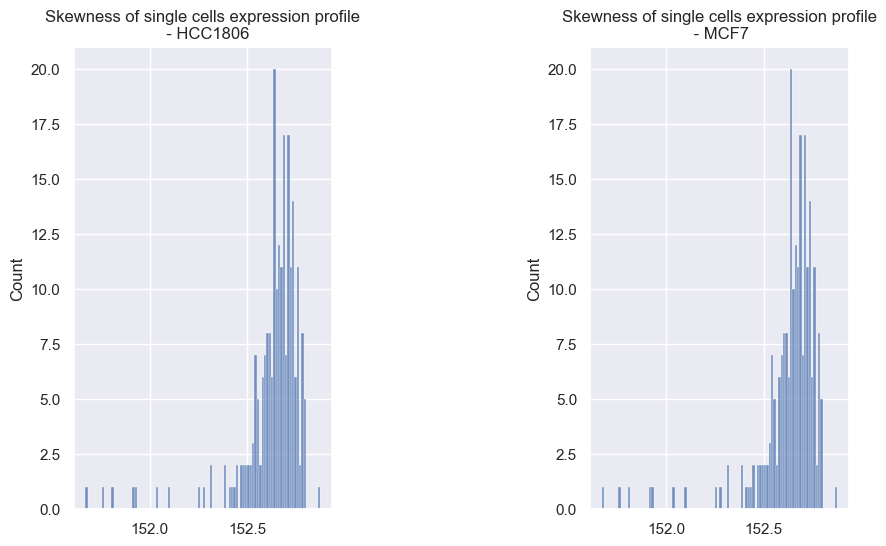

In [35]:
hcc_column_skewness = [skew(ss_hcc_final[col]) for col in ss_hcc_final.columns]
mcf_column_skewness = [skew(ss_hcc_final[col]) for col in ss_hcc_final.columns]

fig, axs = plt.subplots(1, 2, figsize = (10, 6))
axs[0].set_title('Skewness of single cells expression profile\n  - HCC1806')
axs[1].set_title('Skewness of single cells expression profile\n - MCF7')

sns.histplot(hcc_column_skewness, bins=100, ax=axs[0])
sns.histplot(mcf_column_skewness, bins=100, ax=axs[1])

plt.subplots_adjust(wspace=1)

plt.show()

<i>Kurtosis</i> is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case. <a href = "https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Skewness%20is%20a%20measure%20of,relative%20to%20a%20normal%20distribution.">link</a>

For univariate data $Y_1, Y_2, ..., Y_N$, the formula for <i>kurtosis</i> is:
$$\mathbf{kurtosis} = \frac{\sum_{i=1}^{N}(Y_{i} - \bar{Y})^{4}/N}{s^{4}}  - 3$$
where $\bar{Y}$ is the mean, $s$ is the standard deviation, and $N$ is the number of data points. Note that in computing the <i>kurtosis</i>, the standard deviation is computed using $N$ in the denominator rather than $N - 1$.

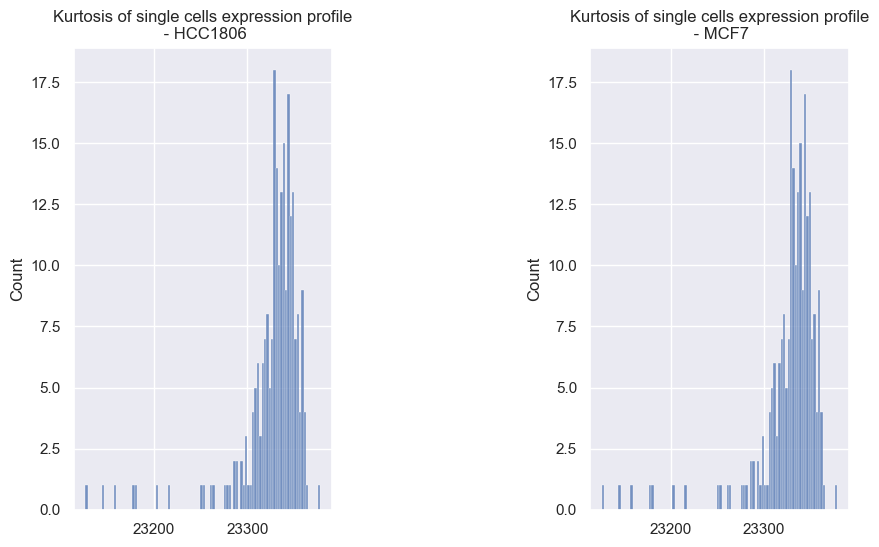

In [36]:
hcc_column_kurtosis = [kurtosis(ss_hcc_final[col]) for col in ss_hcc_final.columns]
mcf_column_kurtosis = [kurtosis(ss_hcc_final[col]) for col in ss_hcc_final.columns]

fig, axs = plt.subplots(1, 2, figsize = (10, 6))
axs[0].set_title('Kurtosis of single cells expression profile\n - HCC1806')
axs[1].set_title('Kurtosis of single cells expression profile\n - MCF7')

sns.histplot(hcc_column_kurtosis, bins=100, ax=axs[0])
sns.histplot(mcf_column_kurtosis, bins=100, ax=axs[1])

plt.subplots_adjust(wspace=1)

plt.show()

Indeed the <i>skewnesss</i> and <i>kurtosis</i> are very high. This confirms our initial visual inspection of the violin plots. For comparison, we compute the <i>skewness</i> and <i>kurtosis</i> for several distributions below. 

normal distribution: skewness = 0.007282723466752722, kurtosis = -0.04093422703798044
uniform distribution: skewness = -0.006653092059314285, kurtosis = -1.1889881206129669
exp distribution: skewness = 1.8779286685664232, kurtosis = 4.891504539989963
poisson distribution: skewness = 0.9940803937862223, kurtosis = 1.043416727105737


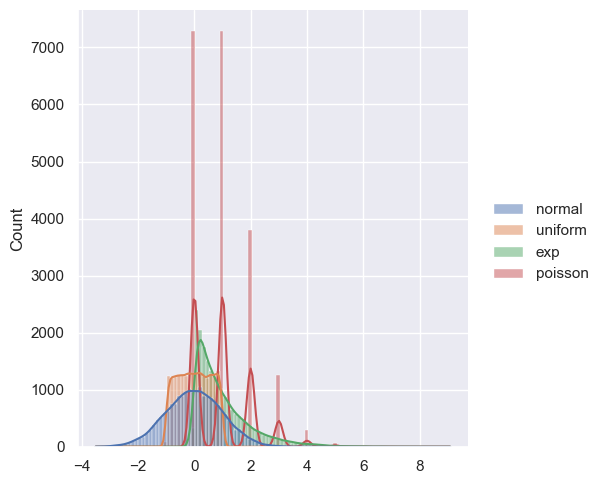

In [37]:
dist_samples = {}

dist_samples['normal'] = np.random.normal(0, 1, 20000)
dist_samples['uniform'] = np.random.uniform(-1, 1, 20000)
dist_samples['exp'] = np.random.exponential(1, 20000)
dist_samples['poisson'] = np.random.poisson(1, 20000)

for key, value in dist_samples.items():
    print(f'{key} distribution: skewness = {skew(value)}, kurtosis = {kurtosis(value)}')

sns.displot(dist_samples, bins=100, kde=True)

#### Applying Log Transformation

 <a href="https://developers.google.com/machine-learning/data-prep/transform/normalization"><i>Log normalization</i></a> makes your data more symmetrical and therefore, a parametric statistical test will provide you with a more accurate and relevant answer. 
 
 - Gene expression data is often highly skewed, with a few genes having extremely high expression values that can dominate the analysis. By applying a logarithmic transformation, we can compress the dynamic range of expression values and reduce the impact of extremes, making the data more suitable for statistical analysis. [more](https://blog.qbaseplus.com/seven-tips-for-bio-statistical-analysis-of-gene-expression-data)
 - Log normalization can help to adjust for differences in sequencing depth or library size between samples. Since the number of reads obtained for each gene is proportional to the sequencing depth, normalization can account for differences in library size and ensure that the expression values are comparable across samples.

Overall, log normalization can help to improve the accuracy and reliability of downstream analyses, such as differential expression analysis, clustering, and classification. The logarithmic base 2 is commonly used to represent a doubling (+1) or halving (-1) of the feature abundance. Therefore, when comparing gene expression levels to a control, both up-regulation and down-regulation are treated symmetrically.

To log normalize, the feature counts for each cell are divided by the total counts for that cell and multiplied by the scale factor (1e6 by default). This is then natural-log transformed using log2b.

<a href="https://developers.google.com/machine-learning/data-prep/transform/normalization">Other methods</a> include: 
- Min-max normalization
- Z-score normalization
- Decimal scaling normalization
- Unit vector normalization
- [GLM normalization](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.biorxiv.org/content/10.1101/576827v1.full.pdf)
- <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/boxcoxno.htm">Box-Cox normalization</a>

Below we apply log normalization to the data. 

In [48]:

ss_hcc_unfiltered_lognorm = ss_hcc_unfiltered.div(ss_hcc_unfiltered.sum(axis=0), axis=1) * 1e6 # inter/instra cell normalization
ss_hcc_unfiltered_lognorm = ss_hcc_unfiltered_lognorm + 1
ss_hcc_unfiltered_lognorm = ss_hcc_unfiltered_lognorm.apply(np.log2)

ss_mcf_unfiltered_lognorm = ss_mcf_unfiltered.div(ss_mcf_unfiltered.sum(axis=0), axis=1) * 1e6 # inter/intra cell normalization
ss_mcf_unfiltered_lognorm = ss_mcf_unfiltered_lognorm + 1
ss_mcf_unfiltered_lognorm = ss_mcf_unfiltered_lognorm.apply(np.log2)    

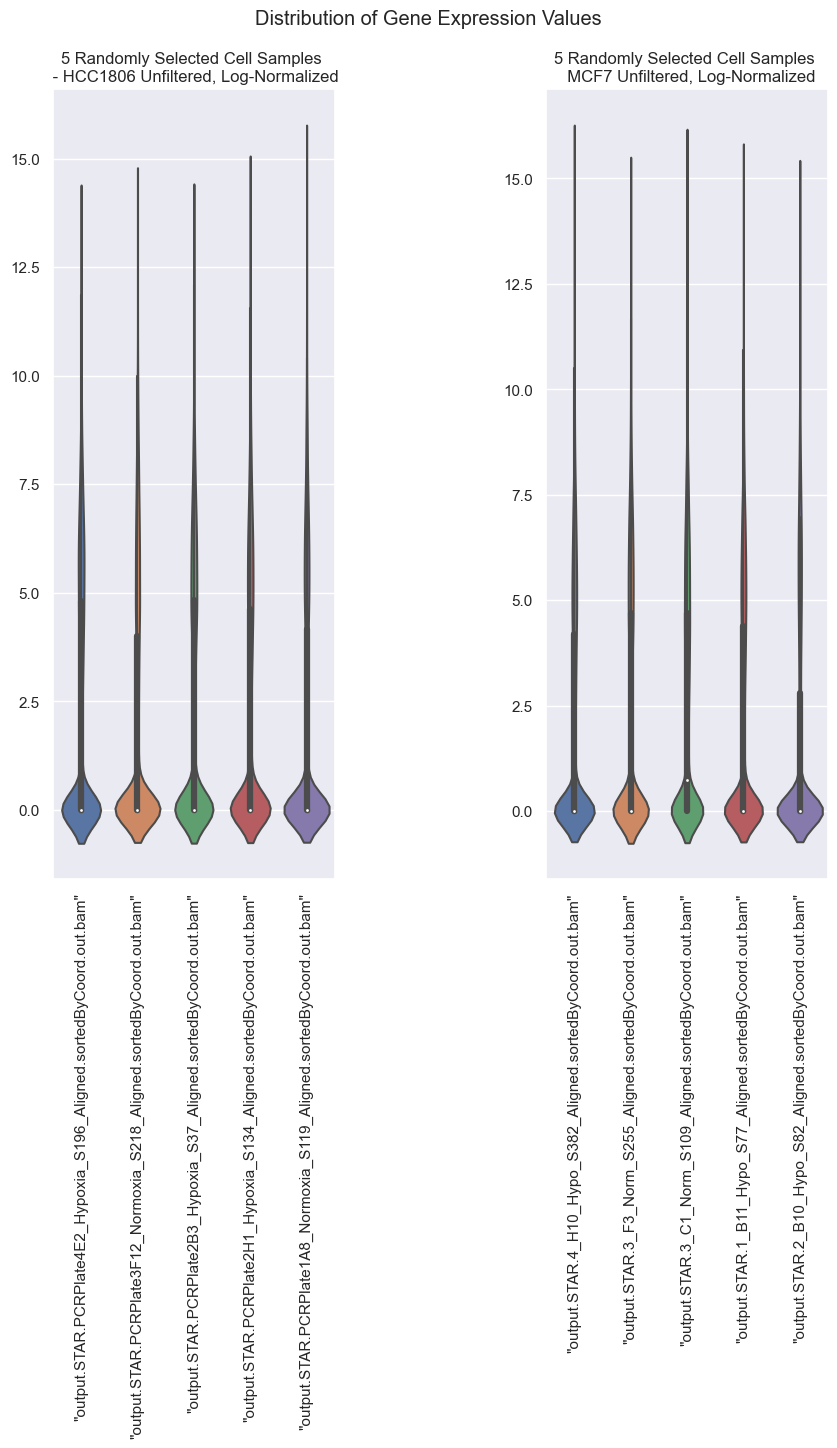

In [49]:
hcc_column_sample = random.sample(unfiltered_hcc_columns, 5)
mcf_column_sample = random.sample(unfiltered_mcf_columns, 5)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

plt.suptitle("Distribution of Gene Expression Values")
axs[0].set_title("5 Randomly Selected Cell Samples \n - HCC1806 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_hcc_unfiltered_lognorm[hcc_column_sample], ax=axs[0])
plt.setp(plot.get_xticklabels(), rotation=90)

axs[1].set_title("5 Randomly Selected Cell Samples \n  MCF7 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_mcf_unfiltered_lognorm[mcf_column_sample], ax=axs[1])
plt.setp(plot.get_xticklabels(), rotation=90)

plt.subplots_adjust(top=0.9, wspace=0.75)
plt.show()

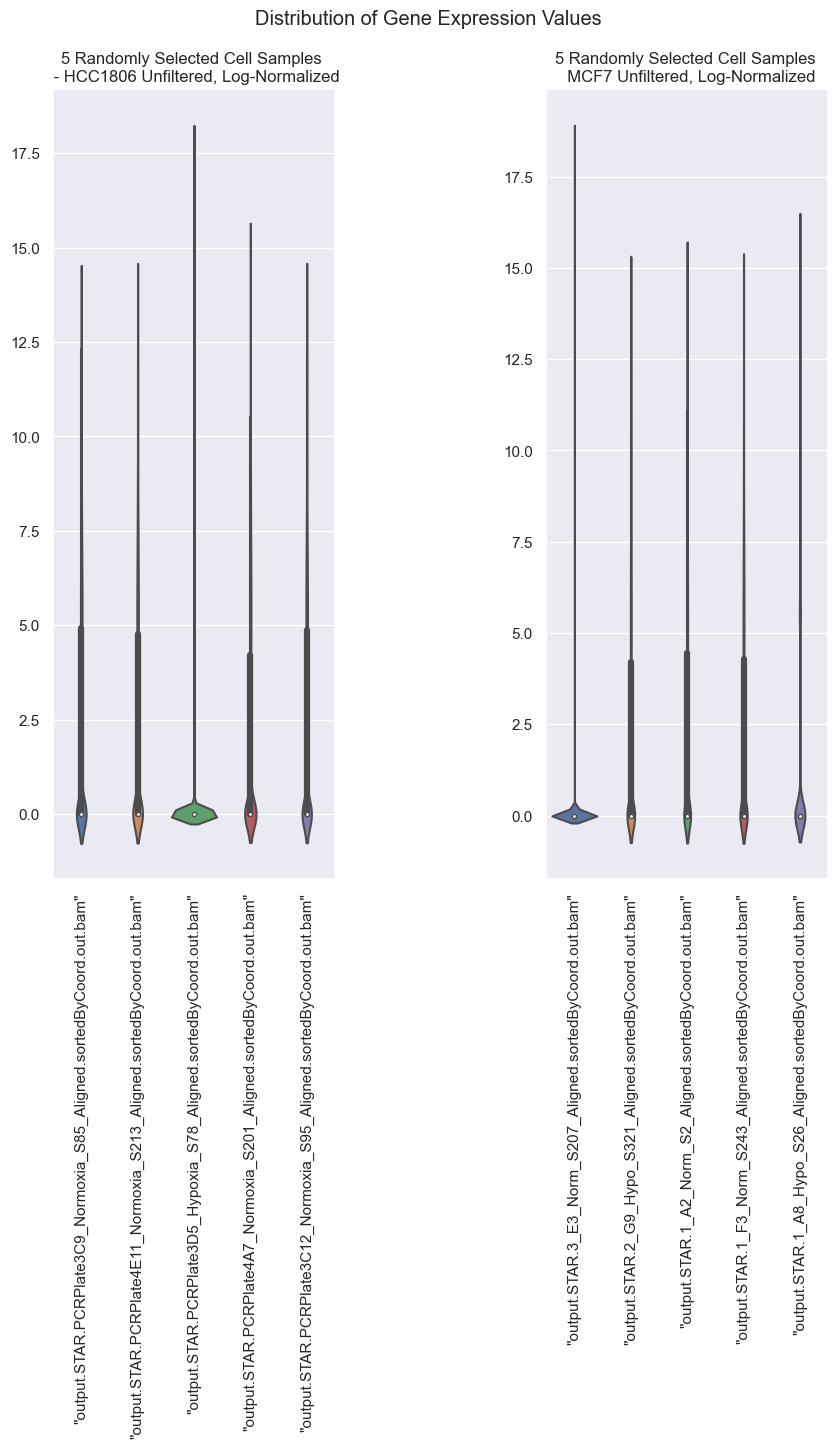

In [50]:
hcc_column_sample = random.sample(unfiltered_hcc_columns, 5)
mcf_column_sample = random.sample(unfiltered_mcf_columns, 5)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

plt.suptitle("Distribution of Gene Expression Values")
axs[0].set_title("5 Randomly Selected Cell Samples \n - HCC1806 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_hcc_unfiltered_lognorm[hcc_column_sample], ax=axs[0])
plt.setp(plot.get_xticklabels(), rotation=90)

axs[1].set_title("5 Randomly Selected Cell Samples \n  MCF7 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_mcf_unfiltered_lognorm[mcf_column_sample], ax=axs[1])
plt.setp(plot.get_xticklabels(), rotation=90)

plt.subplots_adjust(top=0.9, wspace=0.75)
plt.show()

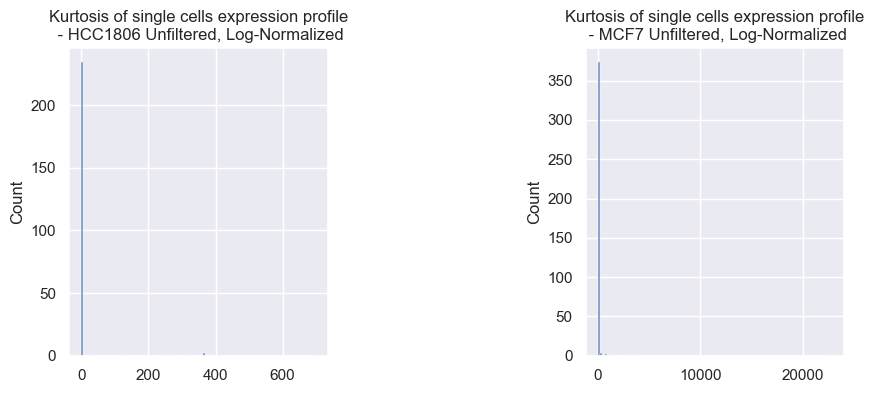

In [8]:
hcc_lognorm_column_kurtosis = [kurtosis(ss_hcc_unfiltered_lognorm[col]) for col in ss_hcc_unfiltered_lognorm.columns]
mcf_lognorm_column_kurtosis = [kurtosis(ss_mcf_unfiltered_lognorm[col]) for col in ss_mcf_unfiltered_lognorm.columns]

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].set_title('Kurtosis of single cells expression profile\n - HCC1806 Unfiltered, Log-Normalized')
axs[1].set_title('Kurtosis of single cells expression profile\n - MCF7 Unfiltered, Log-Normalized')

sns.histplot(hcc_lognorm_column_kurtosis, bins=100, ax=axs[0])
sns.histplot(mcf_lognorm_column_kurtosis, bins=100, ax=axs[1])

plt.subplots_adjust(wspace=1)

plt.show()

We can see that the <i>skewness</i> and <i>kurtosis</i> are much lower after log normalization. However, we can notice that for a few of the cell gene profiles the <i>skewness</i> is still high. Why is this the case? Should we apply a different normalization technique or should we remove these cell samples from our dataset?

#### Conclusion

Below we plot the distribution of single cell gene profiles after log-normalization.

/Users/daniyarzakarin/Documents/code/uni/bailab/bailab/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/Users/daniyarzakarin/Documents/code/uni/bailab/bailab/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


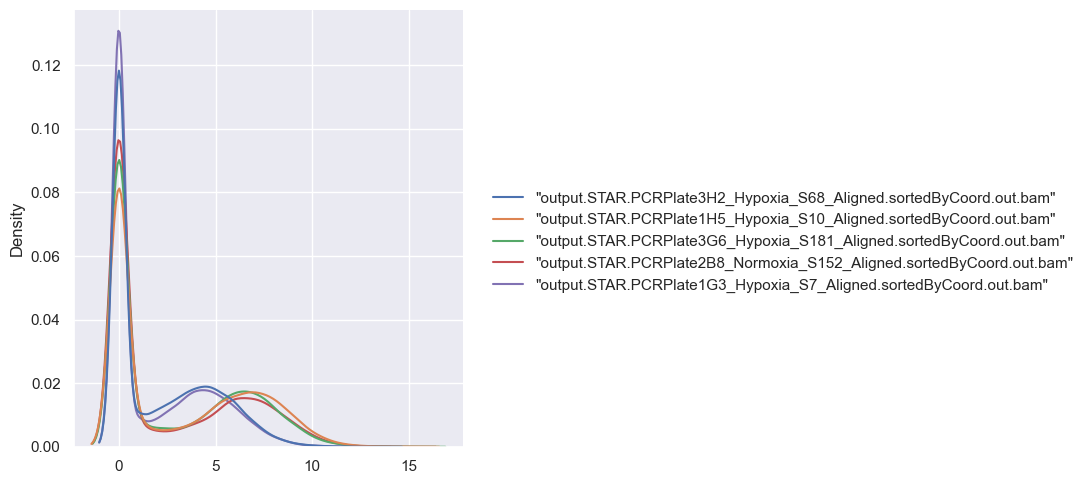

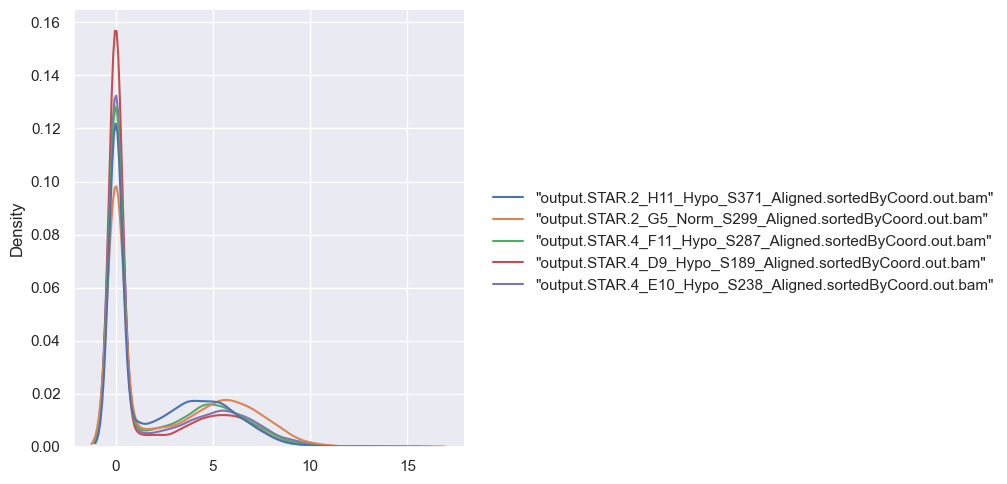

In [13]:
hcc_column_sample = random.sample(unfiltered_hcc_columns, 5)
mcf_column_sample = random.sample(unfiltered_mcf_columns, 5)

sns.displot(data=ss_hcc_unfiltered_lognorm[hcc_column_sample], ax=axs[0], kind="kde")
sns.displot(data=ss_mcf_unfiltered_lognorm[mcf_column_sample], ax=axs[1], kind="kde")

The apparent bimodal shape of the graphs is due to the fact that most genes are not expressed in a given cell. This is a common feature of gene expression data. If we look only at the positive values, we can see that the distribution is quite symmetric. 

Let's compare cumilative distribution functions of the data pre and post normalization.

<Axes: title={'center': 'After Log-Normalization'}, ylabel='Proportion'>

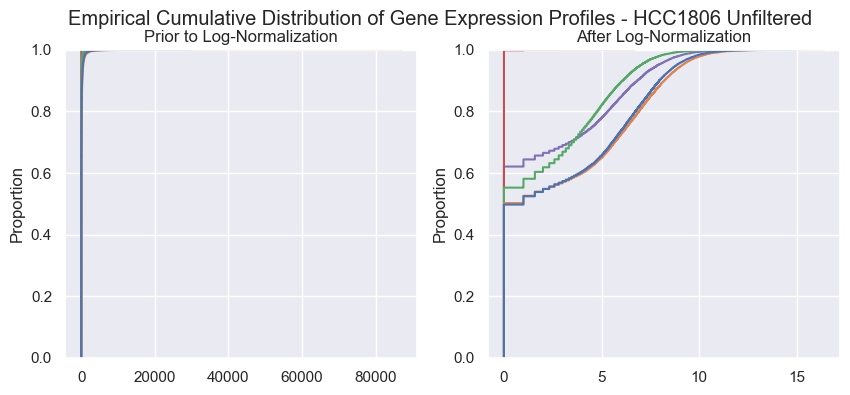

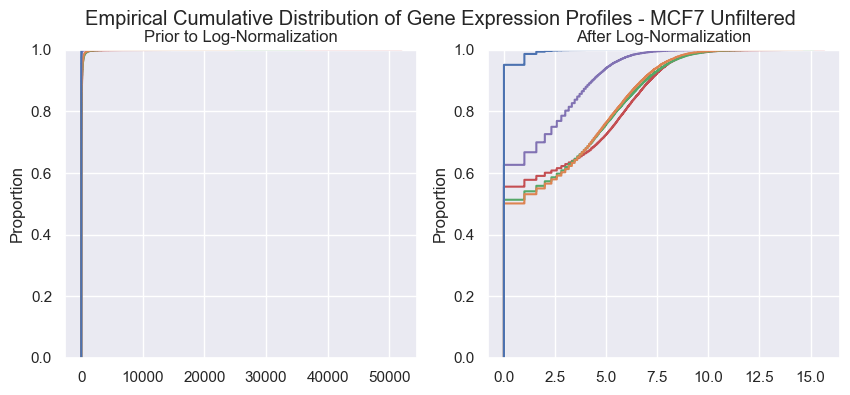

In [14]:
hcc_column_sample = random.sample(unfiltered_hcc_columns, 5)
mcf_column_sample = random.sample(unfiltered_mcf_columns, 5)

# HCC1806 Unfiltered
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

plt.suptitle("Empirical Cumulative Distribution of Gene Expression Profiles - HCC1806 Unfiltered")
axs[0].set_title("Prior to Log-Normalization")
axs[1].set_title("After Log-Normalization")

sns.ecdfplot(data=ss_hcc_unfiltered[hcc_column_sample], ax=axs[0], legend=False)
sns.ecdfplot(data=ss_hcc_unfiltered_lognorm[hcc_column_sample], ax=axs[1], legend=False)
plt.plot()

# MCF7 Unfiltered
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

plt.suptitle("Empirical Cumulative Distribution of Gene Expression Profiles - MCF7 Unfiltered")
axs[0].set_title("Prior to Log-Normalization")
axs[1].set_title("After Log-Normalization")

sns.ecdfplot(data=ss_mcf_unfiltered[mcf_column_sample], ax=axs[0], legend=False)
sns.ecdfplot(data=ss_mcf_unfiltered_lognorm[mcf_column_sample], ax=axs[1], legend=False)

- Firstly, we notice that around half of the gene are not expressed in a given cell. 

- Secondly, to growth of the empirical cumulative distribution function prior-normalization is very high, so linear normalization methods would not be effective.

Now, let's look at the datasets after normalization. We use violin plots to visualize the distributions of the data. We only plot random 50 cells for each dataset. 


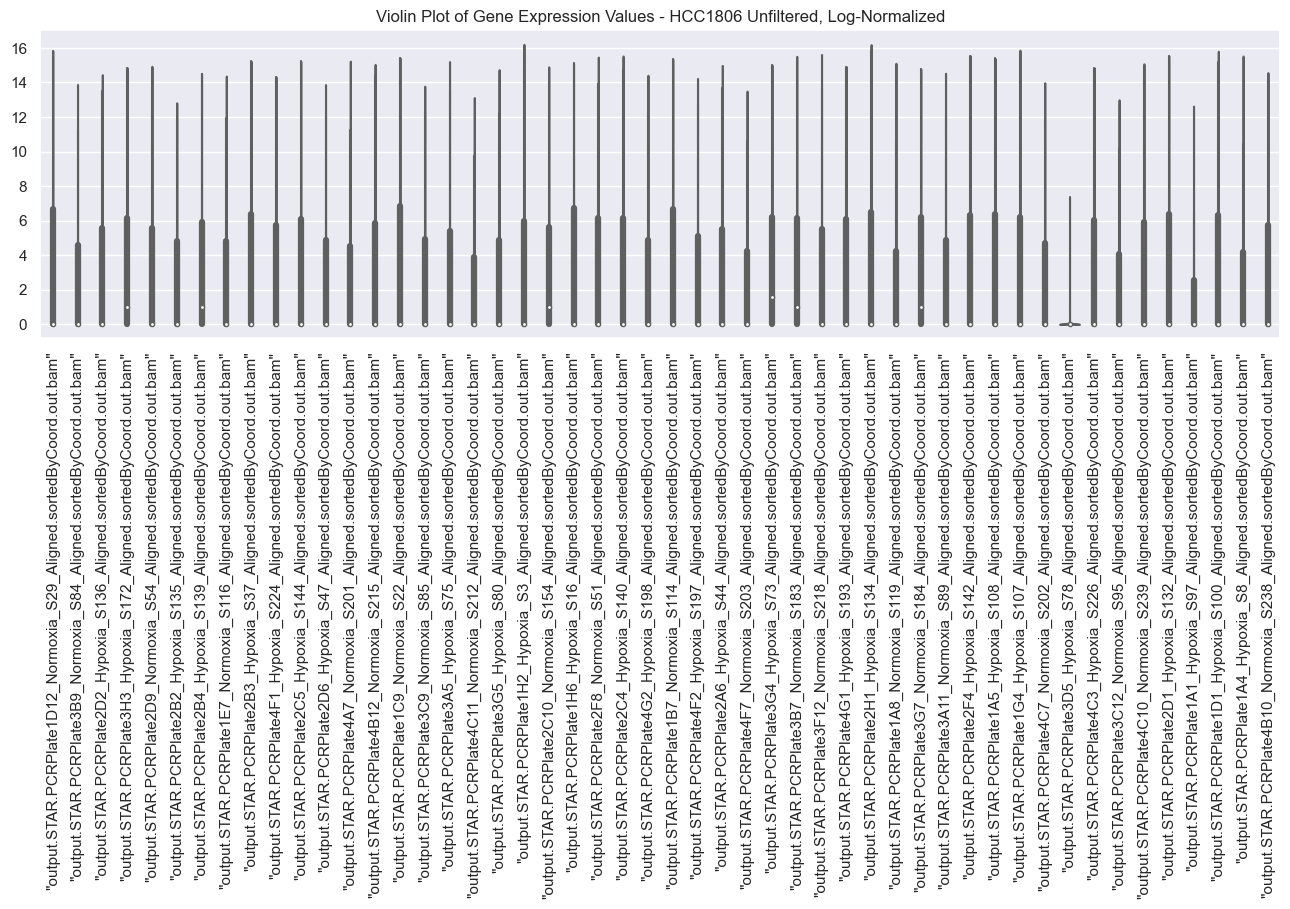

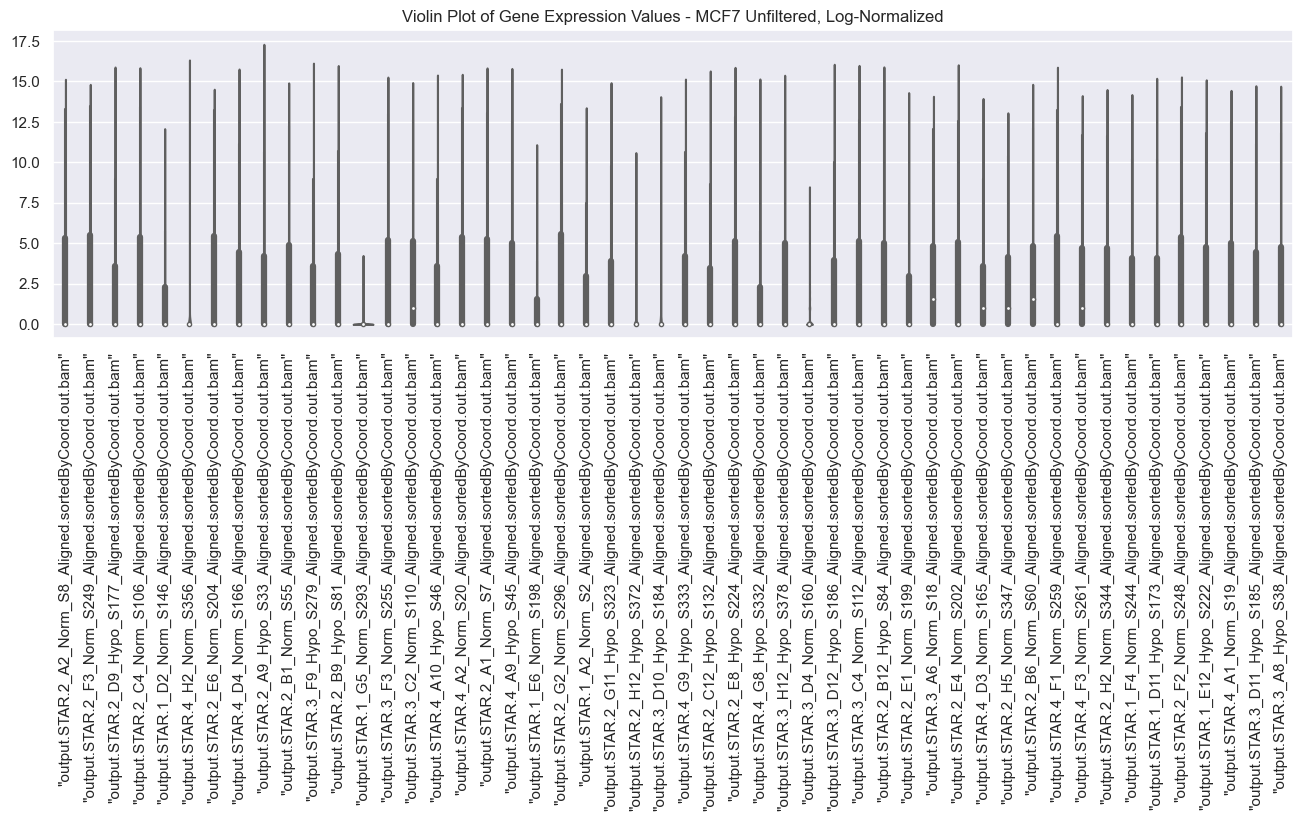

In [15]:
hcc_column_sample = random.sample(unfiltered_hcc_columns, 50)
mcf_column_sample = random.sample(unfiltered_mcf_columns, 50)

plt.figure(figsize=(16,4))
plt.title("Violin Plot of Gene Expression Values - HCC1806 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_hcc_unfiltered_lognorm[hcc_column_sample], palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

plt.figure(figsize=(16,4))
plt.title("Violin Plot of Gene Expression Values - MCF7 Unfiltered, Log-Normalized")
plot = sns.violinplot(data=ss_mcf_unfiltered_lognorm[mcf_column_sample], palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

We can see that the distributions are mostly on the same scale, with few exceptions. Below we plot the boxplots of the gene expression values for each gene separately. We check if the distributions are on the same scale. 


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

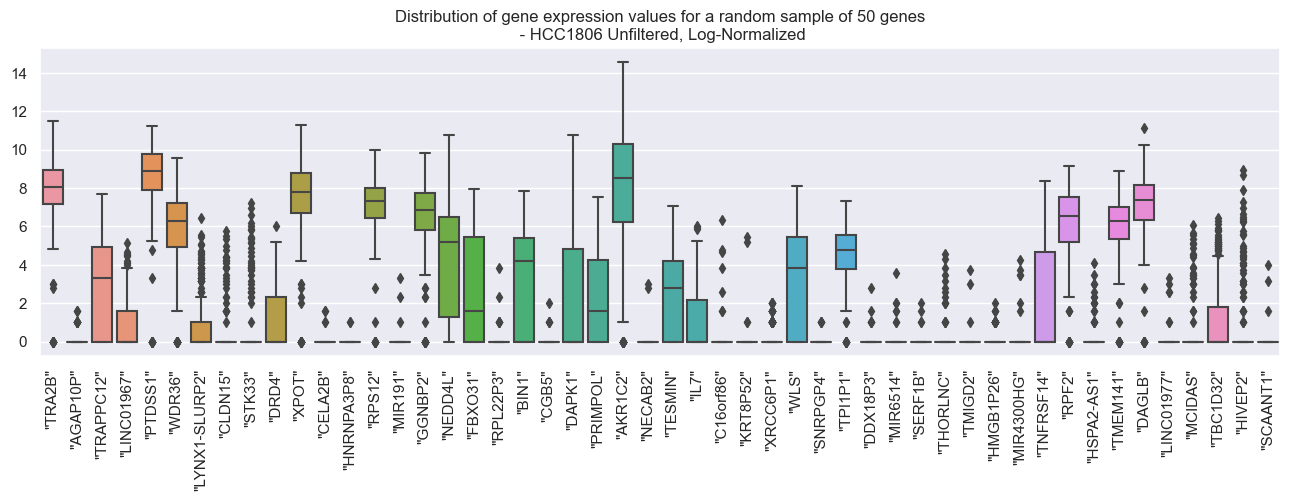

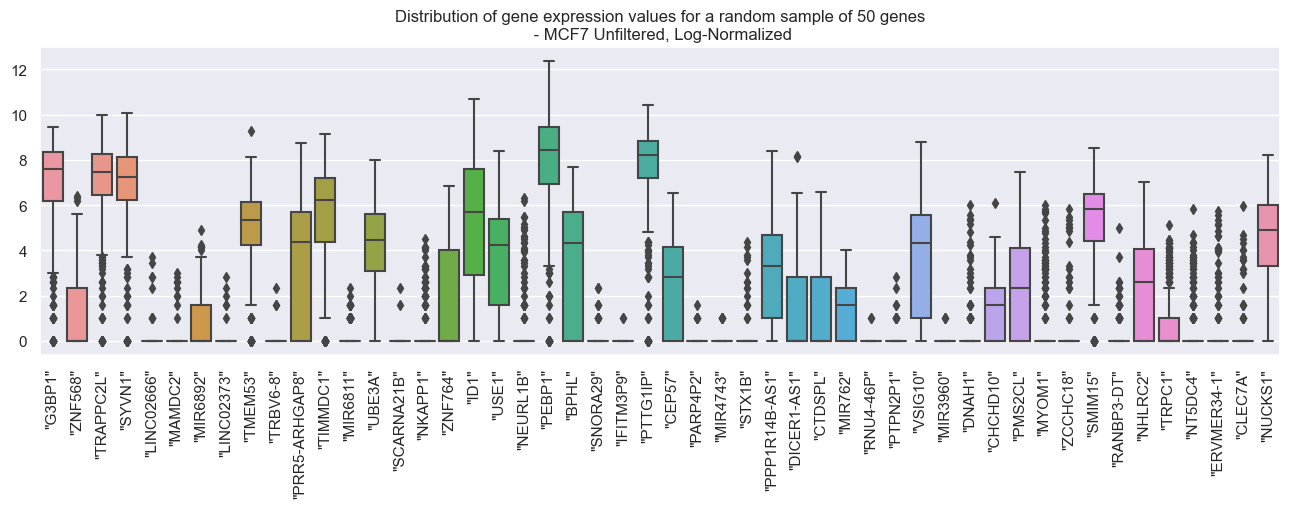

In [16]:
hcc_row_sample = random.sample(unfiltered_hcc_rows, 50)
mcf_row_sample = random.sample(unfiltered_mcf_rows, 50)

ss_hcc_unfiltered_lognorm_transposed = ss_hcc_unfiltered_lognorm.transpose()
ss_mcf_unfiltered_lognorm_transposed = ss_mcf_unfiltered_lognorm.transpose()

plt.figure(figsize=(16,4))
plt.title('Distribution of gene expression values for a random sample of 50 genes\n - HCC1806 Unfiltered, Log-Normalized')
plot = sns.boxplot(data = ss_hcc_unfiltered_lognorm_transposed[hcc_row_sample])
plt.setp(plot.get_xticklabels(), rotation=90)

plt.figure(figsize=(16,4))
plt.title('Distribution of gene expression values for a random sample of 50 genes\n - MCF7 Unfiltered, Log-Normalized')
plot=sns.boxplot(data = ss_mcf_unfiltered_lognorm_transposed[mcf_row_sample])
plt.setp(plot.get_xticklabels(), rotation=90)

Conclusion: 
- Overall, log-transformation seems to be effective in normalizing the data.
- Visually, we can see that the distributions are mostly on the same scale with the few exceptions. Between different genes, on the other hand, the scale is still varied. 
- There are still few highly skewed distributions. Should we remove these cells from our dataset? Or should we use other normalization methods? (See <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/boxcoxno.htm">Box-Cox normalization</a>)
- About half of genes for a given cell are not expressed. This is a common feature of gene expression data.


### Doublet Removal

### Density/Sparsity Analysis
The sparsity of gene expression data arises from the fact that most genes are not expressed in all cell types or under all conditions. This results in a large number of values in a gene expression matrix being zero. The sparsity plot below visualizes the non-zero values of a random sample taken from a dataset, indicating the sparsity of the data. 

Text(0.5, 1.0, 'MCF7-Unfiltered (random 1000 rows)')

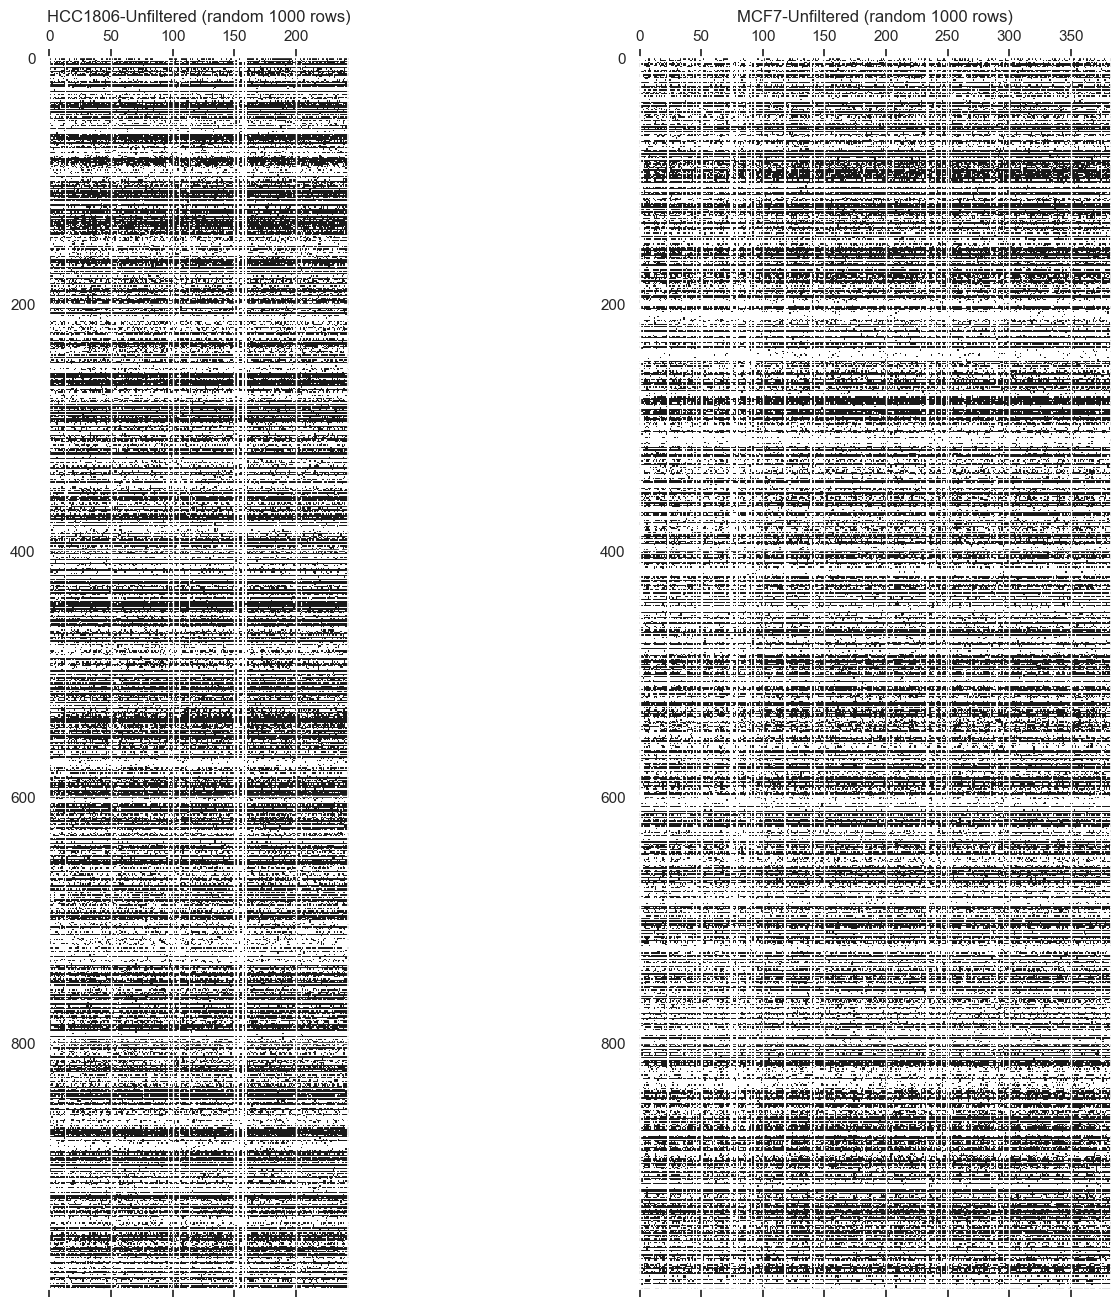

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.spy(np.asarray(ss_hcc_unfiltered.sample(n=1000))) # Shows non-zero elements 
plt.title("HCC1806-Unfiltered (random 1000 rows)");
plt.subplot(1, 2, 2)
plt.spy(np.asarray(ss_mcf_unfiltered.sample(n=1000)))
plt.title('MCF7-Unfiltered (random 1000 rows)')

The sparsity of a dataset can be quantified by calculating the ratio of non-zero values to total values in the matrix. [Read more](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/)

In [ ]:
def sparsity(m : np.ndarray):
    zeros = (m == 0.0).sum()
    return zeros / m.size

hcc, mcf = sparsity(np.asarray(ss_hcc_unfiltered)), sparsity(np.asarray(ss_mcf_unfiltered))
print('Sparsity of HCC1806_Unfitered: ', round(hcc, 4))
print('Sparsity of MCF7_Unfiltered: ', round(mcf, 4))

Sparsity of HCC1806_Unfitered:  0.5585
Sparsity of MCF7_Unfiltered:  0.6022


The [Compressed Sparse Row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix) is commonly used to store such sparse data. It stores the non-zero values and their corresponding column and row indices. This results in a compact representation of the data, reducing memory requirements and improving computational efficiency.

In [ ]:
# Compressed Sparse Row (CSR)
sparse_hcc_unfiltered = csr_matrix(ss_hcc_unfiltered)
sparse_mcf_unfiltered = csr_matrix(ss_mcf_unfiltered)

We compared the total number of bytes used by the dataset elements before and after compression to evaluate the memory saved (note th). However, we did not observe a significant decrease. Therefore, we have decided to proceed with the uncompressed dataset.

Text(0.5, 1.0, 'Compression')

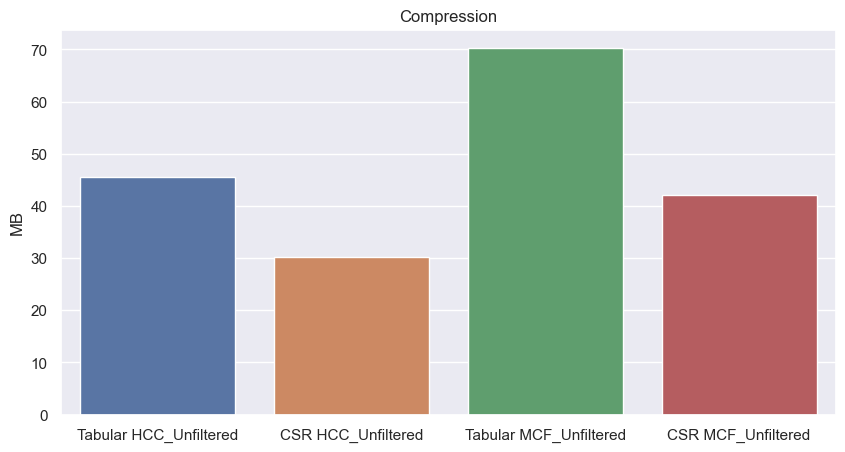

In [ ]:
# Size comparison
fig, ax = plt.subplots(figsize=(10, 5))

dense_hcc_size = np.array(ss_hcc_unfiltered).nbytes/1e6
sparse_hcc_size = (sparse_hcc_unfiltered.data.nbytes + sparse_hcc_unfiltered.indptr.nbytes + sparse_hcc_unfiltered.indices.nbytes)/1e6

dense_mcf_size = np.array(ss_mcf_unfiltered).nbytes/1e6
sparse_mcf_size = (sparse_mcf_unfiltered.data.nbytes + sparse_mcf_unfiltered.indptr.nbytes + sparse_mcf_unfiltered.indices.nbytes)/1e6

sns.barplot(x = ['Tabular HCC_Unfiltered', 'CSR HCC_Unfiltered', 'Tabular MCF_Unfiltered', 'CSR MCF_Unfiltered'],
            y = [dense_hcc_size, sparse_hcc_size, dense_mcf_size, sparse_mcf_size])
plt.ylabel('MB')
plt.title('Compression')

<b>Conclusion</b>: <u>Compressed Sparse Row (CRS)</u> has two benefits:
<ul>
    <li> Reduced memory consumption </li>
    <li> Faster runtime for certain algorithms </li>
</ul>

For the most of the classification and regression algorithms in <b>scikit-learn</b> library, we can use <b>scipy.sparse.csr_matrix</b> representation.

### PCA

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [79]:
def pca(v, data):
    
    pca = PCA()
    # scaler = StandardScaler()
    # data_std = scaler.fit_transform(data)
    pca.fit(data)
    components = pca.fit_transform(data)

    cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cum_var_ratio >= 0.95) + 1

    fig, ax = plt.subplots()
    ax.grid(True)

    ax.set_xlabel('# of components')
    ax.set_ylabel('Variance (%)')
    ax.set_title('Explained Variance: '+ v)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), color=(0.54,0.81,0.94))
    ax.axvline(x = num_components, color='r', linestyle='--')
   
    
    plt.show()

    pca.n_components_
    print("variance explained 95%: "+v+" in " + str(num_components) + " components")
    return pd.DataFrame(data = components)



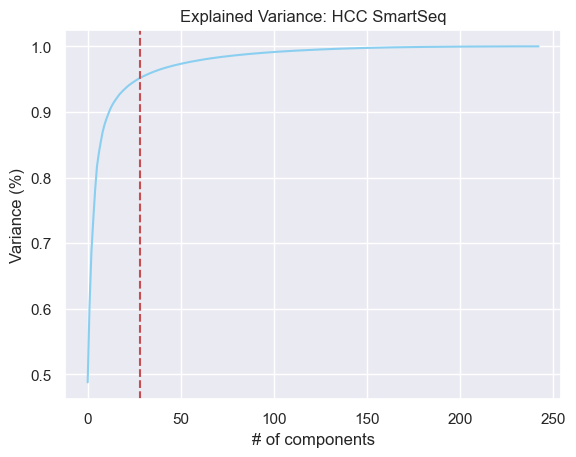

variance explained 95%: HCC SmartSeq in 28 components


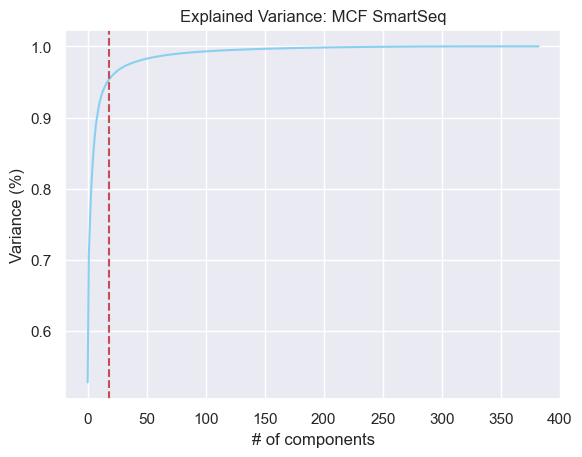

variance explained 95%: MCF SmartSeq in 18 components


In [80]:
ss_hcc_pca = pca("HCC SmartSeq", ss_hcc_unfiltered.T)

#ds_hcc_pca = pca("HCC DropSeq", unfiltered_hcc_columns)

ss_mcf_pca = pca("MCF SmartSeq", ss_mcf_unfiltered.T)
#ds_mcf_pca = pca(mcf_drop_filtered_normalised_train, "MCF DropSeq")

With PCA our aim is to use the minimum number of features (components) in order to explain the data as accurately as possible. We decided that explaining 95% of the variance would achieve us our desired accuracy. 
MCF in this case required a lot less components compared to HCC. This could be related to the homogeneity of expression of MCF cells compared to HCC, which would lead to more information being revealed with fewer number of components.

### Outlier Detection

### Clustering

#### k-means clustering

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [10]:
# initiator function for declaring and applying KMeans
# data is the data to be clustered, n_clusters is the number of clusters expected

def kmeans(datum, Y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(datum)
    clusters = kmeans.fit_predict(datum)
    y_pred = kmeans.predict(datum)

    unique, counts = np.unique(y_pred, return_counts=True)
    print("Cluster counts: ", dict(zip(unique, counts)))
    print("Accuracy score: ", max(accuracy_score(Y, y_pred),1-accuracy_score(Y, y_pred)))
    silhouette(datum, clusters, n_clusters)

#calculates silhouette score and calls the plotting function
def silhouette(datum, labels, n_clusters):
    silh = silhouette_score(datum, labels)
    silhouette_plot(datum, labels, silh, n_clusters)


In [11]:
#Creates a silhouette plot based on given data,
#clusters and pre calculated silhouette score
def silhouette_plot(data, clusters, silhouette, max_k):
    fig, ax = plt.subplots(1,1)
    y_lower = 10
    for i in range(max_k):
        ith_cluster_silhouette_values = \
            silhouette_samples(data, clusters)
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10


    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")
    ax.set_title("Silhouette plot for the various clusters")
    ax.axvline(x=silhouette, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    print("Silhouette score: " + str(silhouette))
    print("-------------------------------------------")



##### Silhouette scores define how well each point of data lies within its cluster, ranging from -1 to 1. Values close to 1 show that datapoints are well separated and placed close to the center within their own cluster, and values closer to -1 indicate that datapoints are closer to other clusters than to their own clusters. 


C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:  {0: 9, 1: 234}
Accuracy score:  0.522633744855967


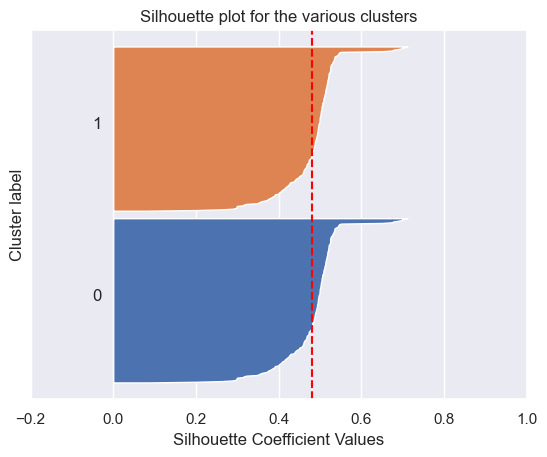

Silhouette score: 0.48117334358282743
-------------------------------------------


C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:  {0: 353, 1: 30}
Accuracy score:  0.5117493472584856


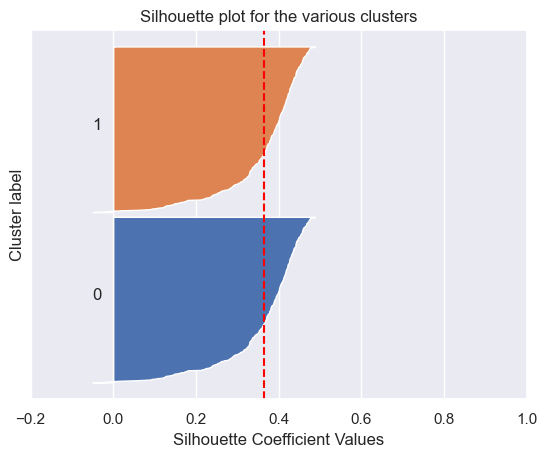

Silhouette score: 0.3644456888763897
-------------------------------------------


In [70]:
mcf_label = mcf_meta["Condition"]
mcf_label = [1 if i == "Hypo" else 0 for i in mcf_label]
hcc_label = hcc_meta["Condition"]
hcc_label = [1 if i == "Hypo" else 0 for i in hcc_label]


kmeans(ss_hcc_unfiltered_lognorm.T, hcc_label, 2)
kmeans(ss_mcf_unfiltered_lognorm.T, mcf_label, 2)

##### Our given silhouette scores 0.3598 and 0.4182 for HCC and MCF respectively imply that clusters individual data points within the same cluster are closer to each other than they are to data points in other clusters. These values, however, aren't particularly high so the resulting cluster graphs become cluttered


C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:  {0: 242, 1: 1}
Accuracy score:  0.522633744855967


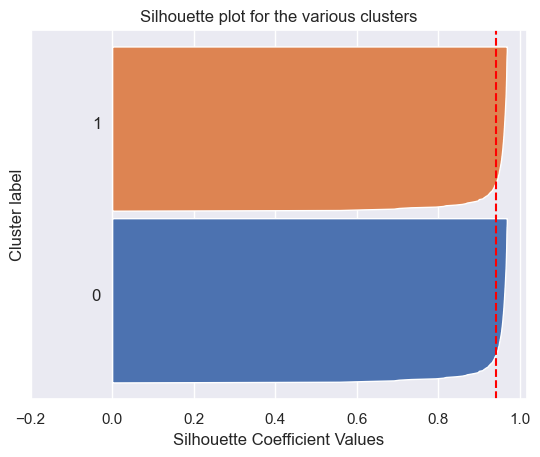

Silhouette score: 0.9419158281225883
-------------------------------------------
Cluster counts:  {0: 382, 1: 1}
Accuracy score:  0.5039164490861618


C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


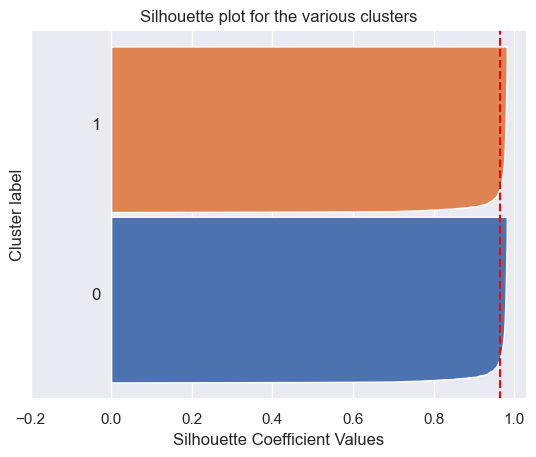

Silhouette score: 0.9658777452644366
-------------------------------------------


In [81]:
kmeans(ss_hcc_pca.T, hcc_label, 2)
kmeans(ss_mcf_pca.T, mcf_label, 2)

##### Filtered data vastly outperforms unfiltered data when there is no PCA involved. This can be seen from the significant percent of negative density in the silhouette plot of the unfiltered data below, which indicates there is a strong minority of data that is closer to other clusters than its own. PCA still is the greatest improvement in performance however, as while rescaling allows obvious outliers to be diluted it still doesn't fix all 

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:  {0: 154, 1: 89}
Accuracy score:  0.6255144032921811


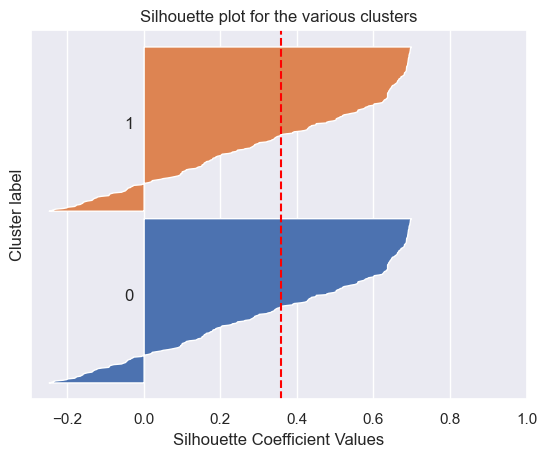

Silhouette score: 0.3597995585925826
-------------------------------------------


C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:  {0: 285, 1: 98}
Accuracy score:  0.7571801566579635


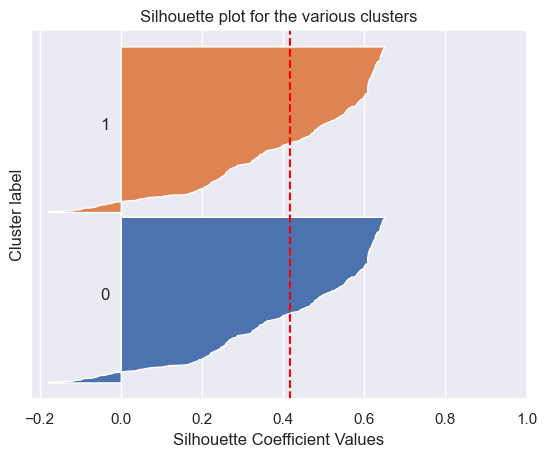

Silhouette score: 0.41825009717259515
-------------------------------------------


In [67]:
kmeans(ss_hcc_unfiltered.T, hcc_label, 2)
kmeans(ss_mcf_unfiltered.T, mcf_label, 2)

##### Running the same clustering method on pca data results in definitive clusters with very high silhouette scores (0.9419 for HCC and 0.9659 for MCF). This is to be expected as pca reduces noise and lowers the dimensionality of the data, resulting in a silhouette plot with very good scores and a cleaner cluster plot. One can clearly see also from the accuracy score that the labeling process was significantly more successful for non-PCA data rather than PCA data (~20% for both cases), which is to be expected as PCA that reduces explained variance will affect also the accuracy of the model.

In [55]:
def elbowgraph(data, max_k): 
    # Initialize lists to store silhouette scores and corresponding K values
    silhouette_scores = []
    k_values = np.arange(2, max_k+1)

    # Iterate over different values of K
    for k in k_values:
        # Fit K-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        # Compute silhouette score
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot the results
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Average Silhouette Width')
    plt.title('Silhouette Analysis')
    plt.show()

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

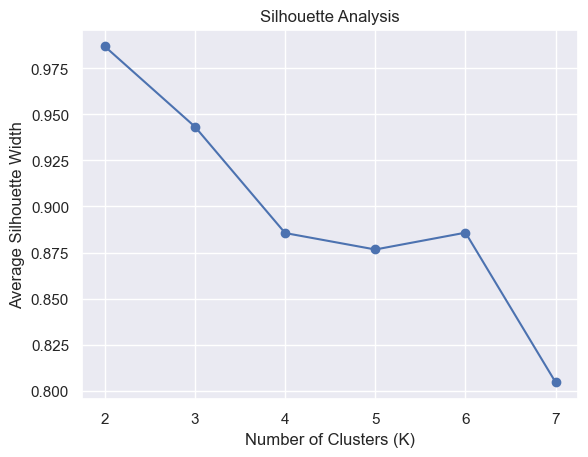

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

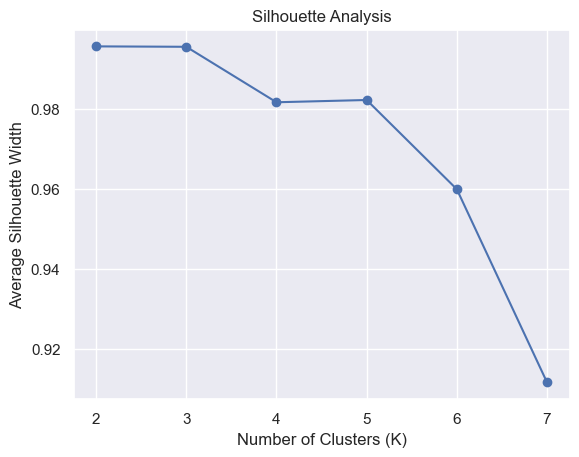

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

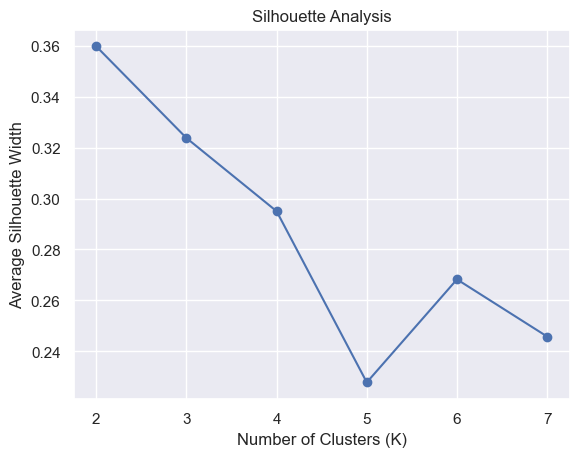

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

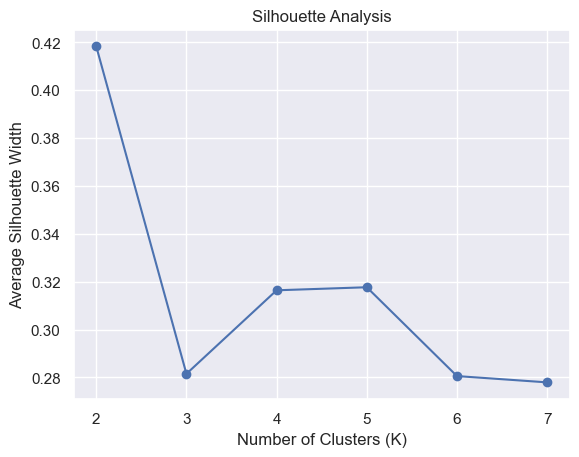

In [56]:
elbowgraph(ss_hcc_unfiltered, 7)
elbowgraph(ss_mcf_unfiltered, 7)
elbowgraph(ss_hcc_pca, 7)
elbowgraph(ss_mcf_pca, 7)

##### From the given average cluster width vs number of clusters graph, we can see that the optimal number of clusters is 2 for any given set of data, MCF or HCC, PCA or non-pca. This is due to average cluster width being high indicating that clusters are more uniform so most points fall close to the center and there are few outliers.

### t-Distributed Stochastic Neighbor Embedding 

#### t-Distributed Stochastic Neighbor Embedding (t-SNE) works by manipulating data with high dimensions into a lower-dimensional space, R squared in our case. It aims to preserve the structure of the data while making visualizing the dataset feasible. t-SNE measures the pairwise similarities between points in the high-dimensional space and recreates said system in a lower-dimensional space. This representation is done with PCA data in order to keep the noise to a minimum and create a clear representation.

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


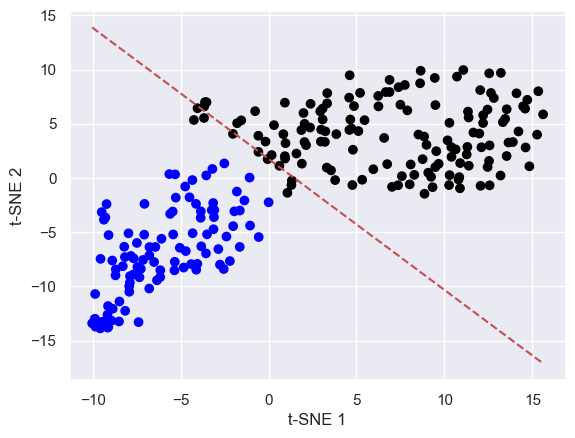

C:\Users\termi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


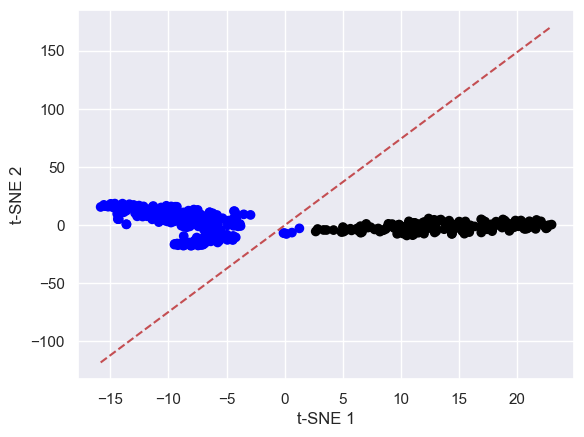

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# X is your high-dimensional data, a numpy array of shape [n_samples, n_features]
#
def tsne(data):

    # TSNE to reduce the dimensions to 2
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(data)

    # KMeans to determine the clusters
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(X_tsne)

    #two centers of the clusters
    cluster1_center = np.mean(X_tsne[clusters == 0], axis=0)
    cluster2_center = np.mean(X_tsne[clusters == 1], axis=0)
    
    # the format of the line is y = mx + b
    m, b = np.polyfit([cluster1_center[0], cluster2_center[0]], [cluster1_center[1], cluster2_center[1]], 1)

    #shifting the line 90 degrees
    m = -1 / m
    b = - b

    colors = ['blue', 'black']
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[colors[cluster] for cluster in clusters])  # Scatter plot of the t-SNE embeddings
    x_vals = np.array([min(X_tsne[:, 0]), max(X_tsne[:, 0])])
    y_vals = m * x_vals + b
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.plot(x_vals, y_vals, 'r--')  # Plot the line
    plt.show()

tsne(ss_hcc_pca)
tsne(ss_mcf_pca)



#### From the given scatter plots of t-SNE it is fairly easy to observe that even when reduced to a 2D plane it is easy to see that the cell data forms two distinct clusters. These clusters represent hypoxic and normoxic cells. The red dotted line separates the clusters in accordance to the middle point between the two cluster centers. While for both graphs there are some outliers that fall onto the wrong side of the red line, overall there is clear division.